In [ ]:
Automated Daily Deal with Special Client and without email client and without file movement 


Sheet Name: Bulk Block Deals
Only Buy or Sell:


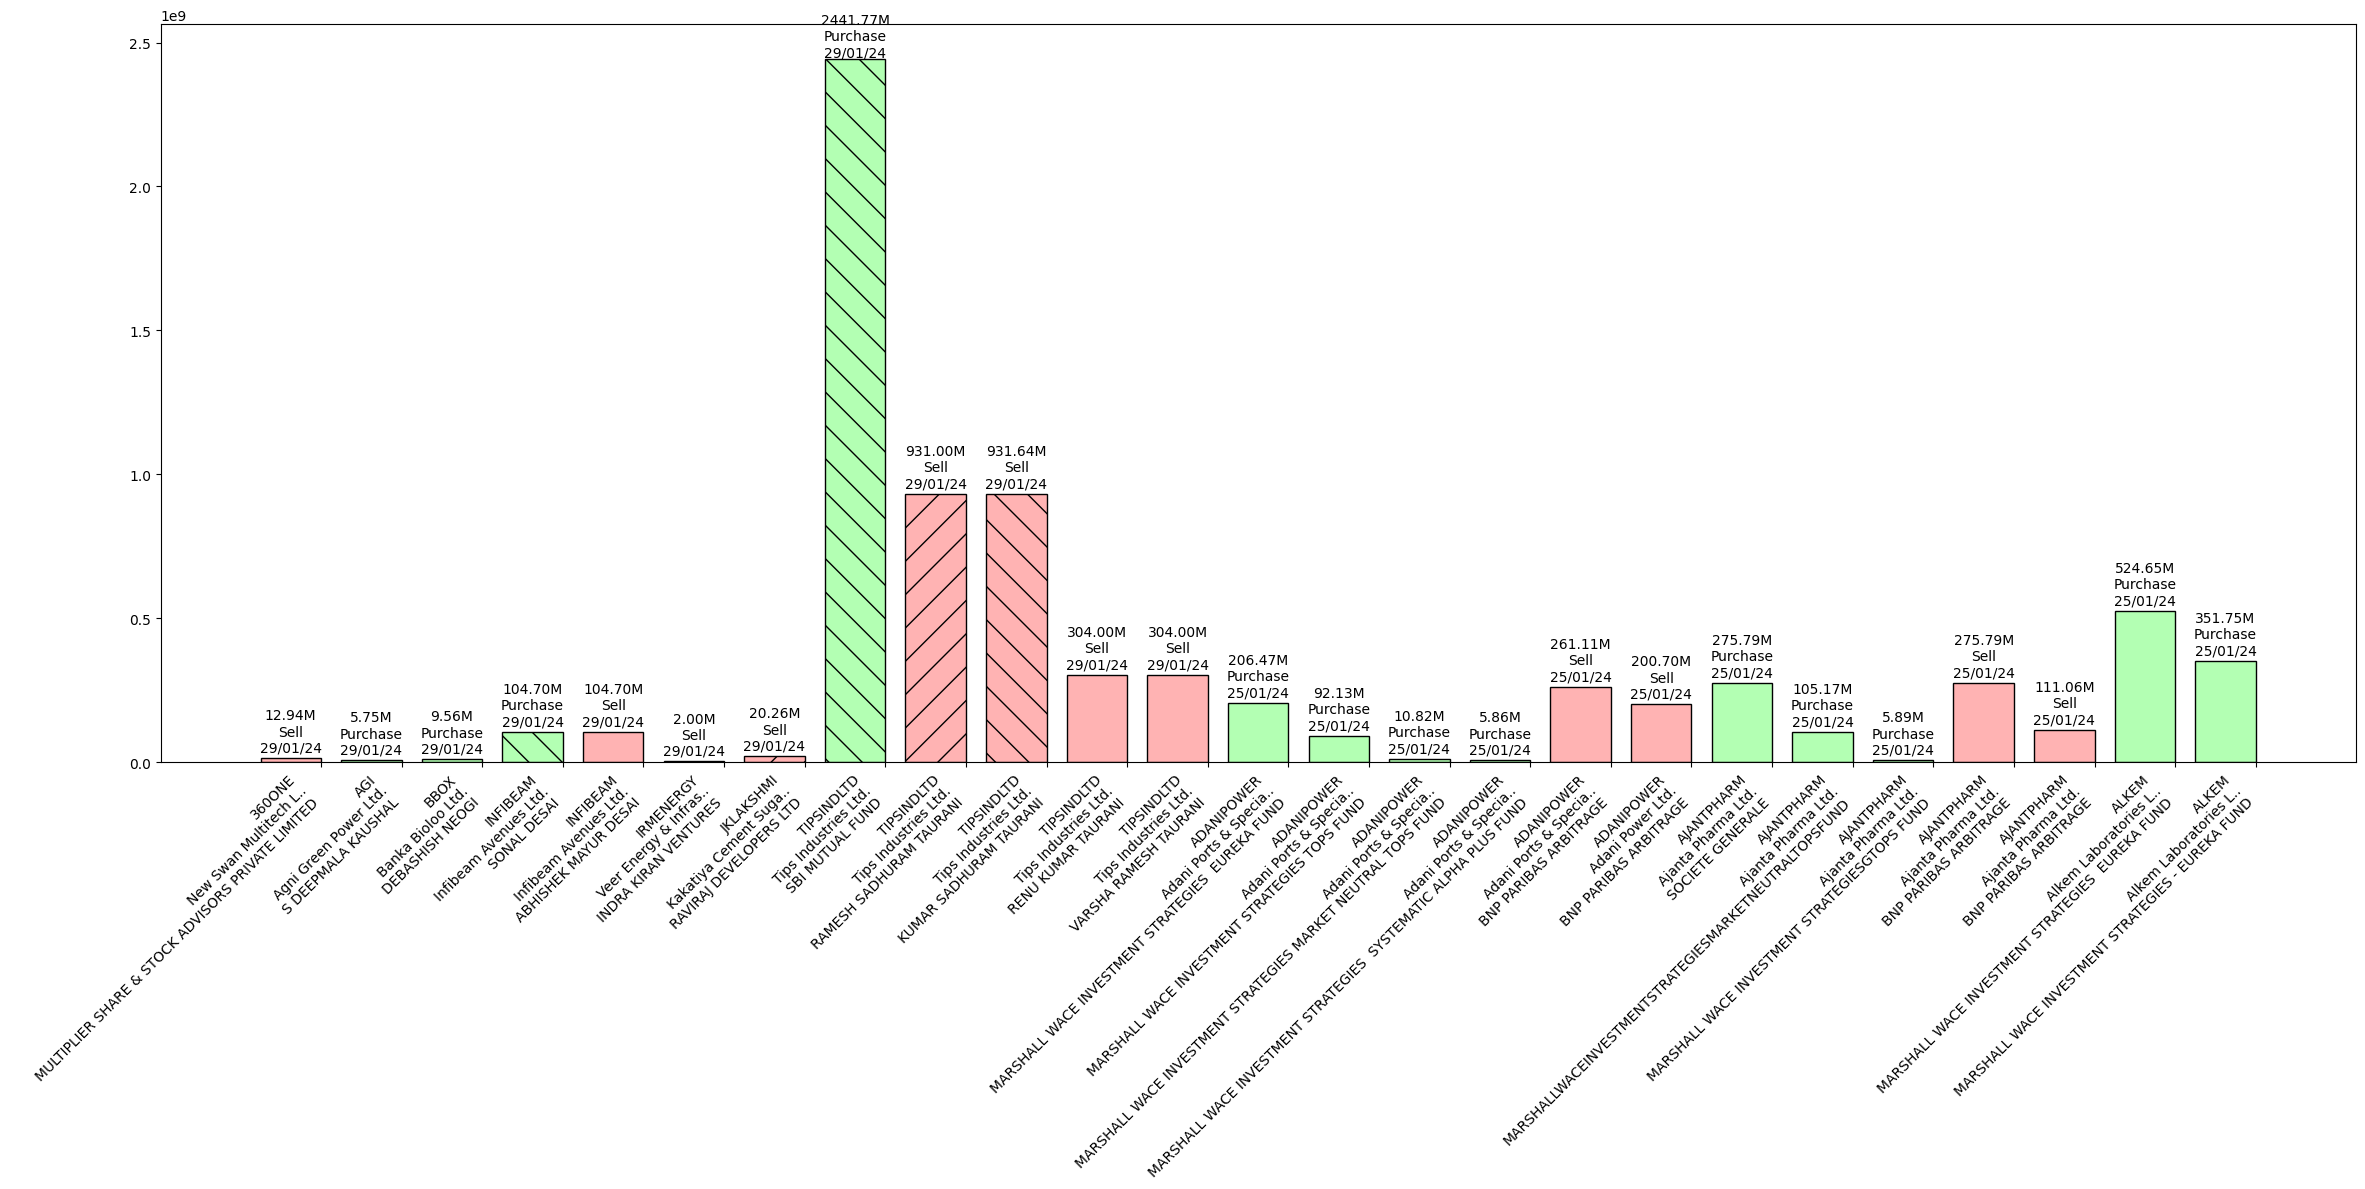

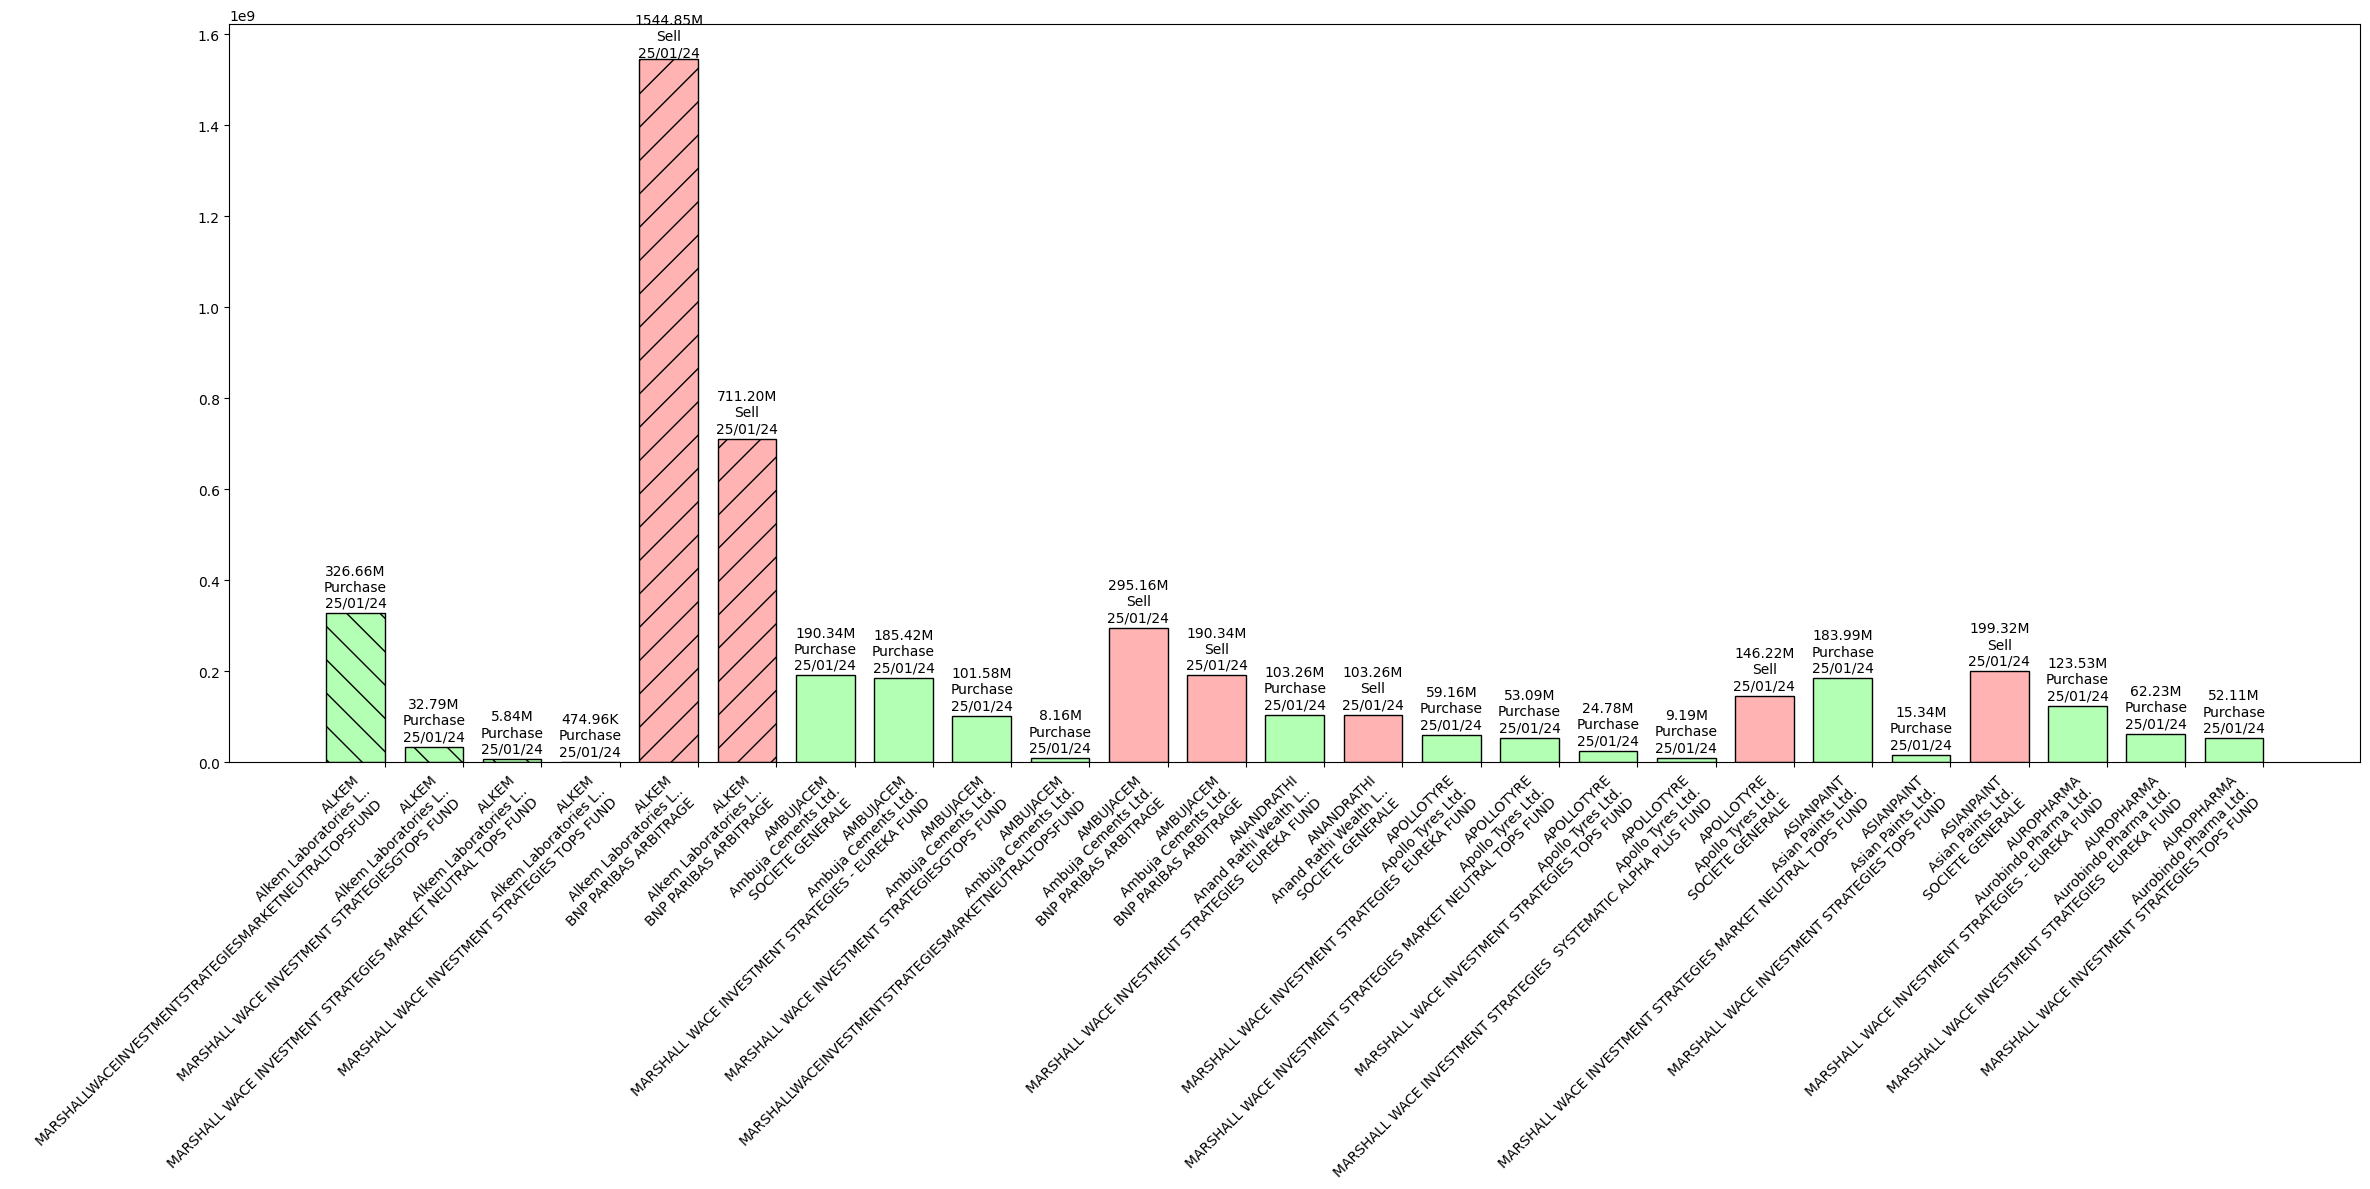

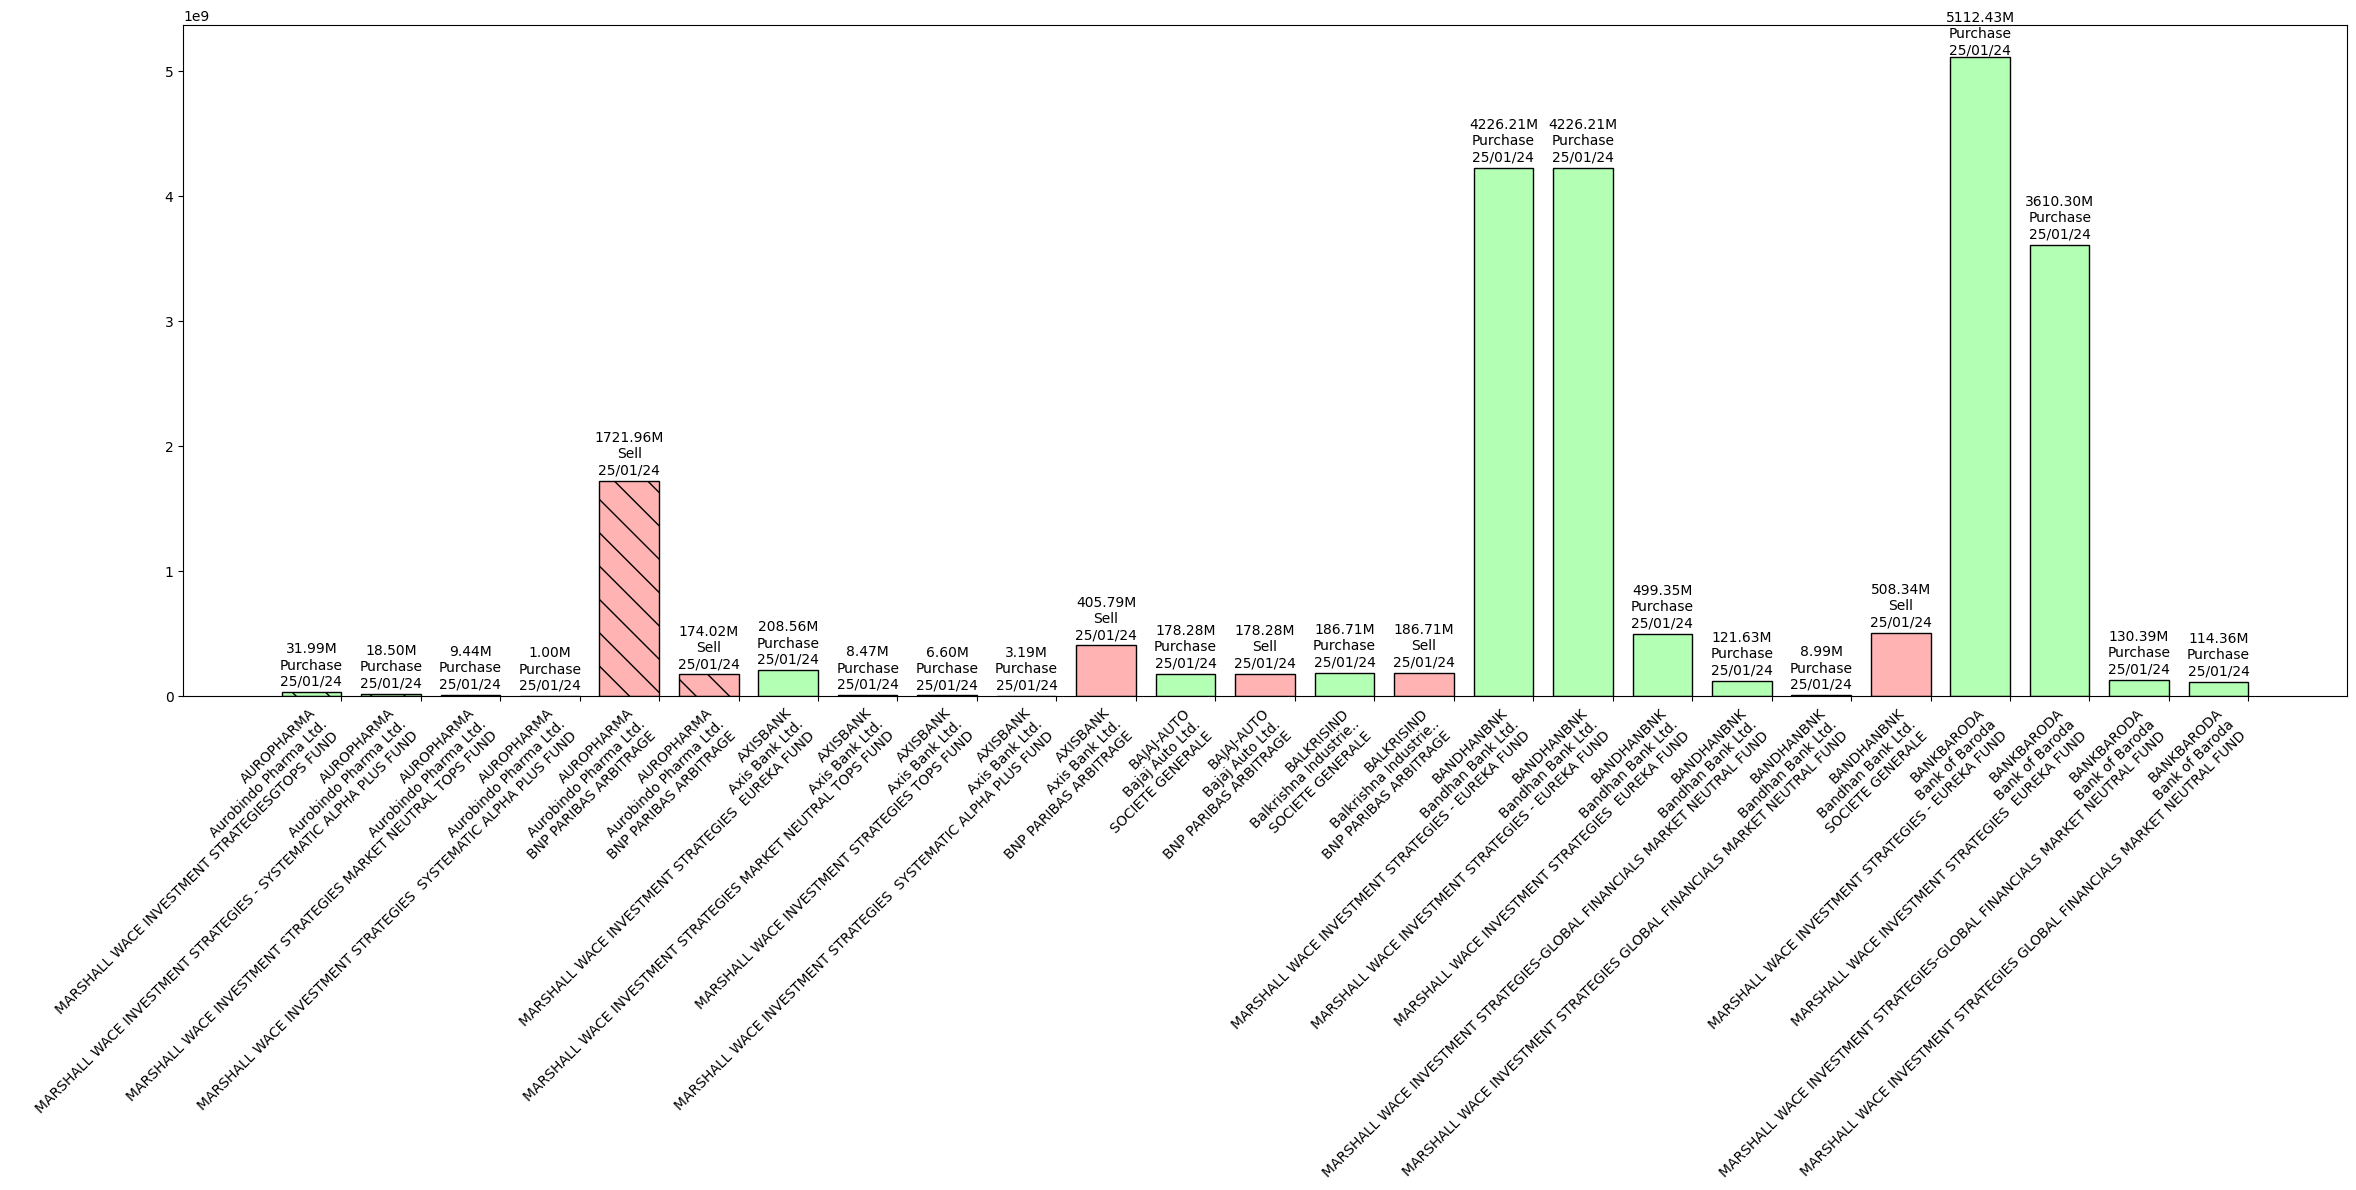

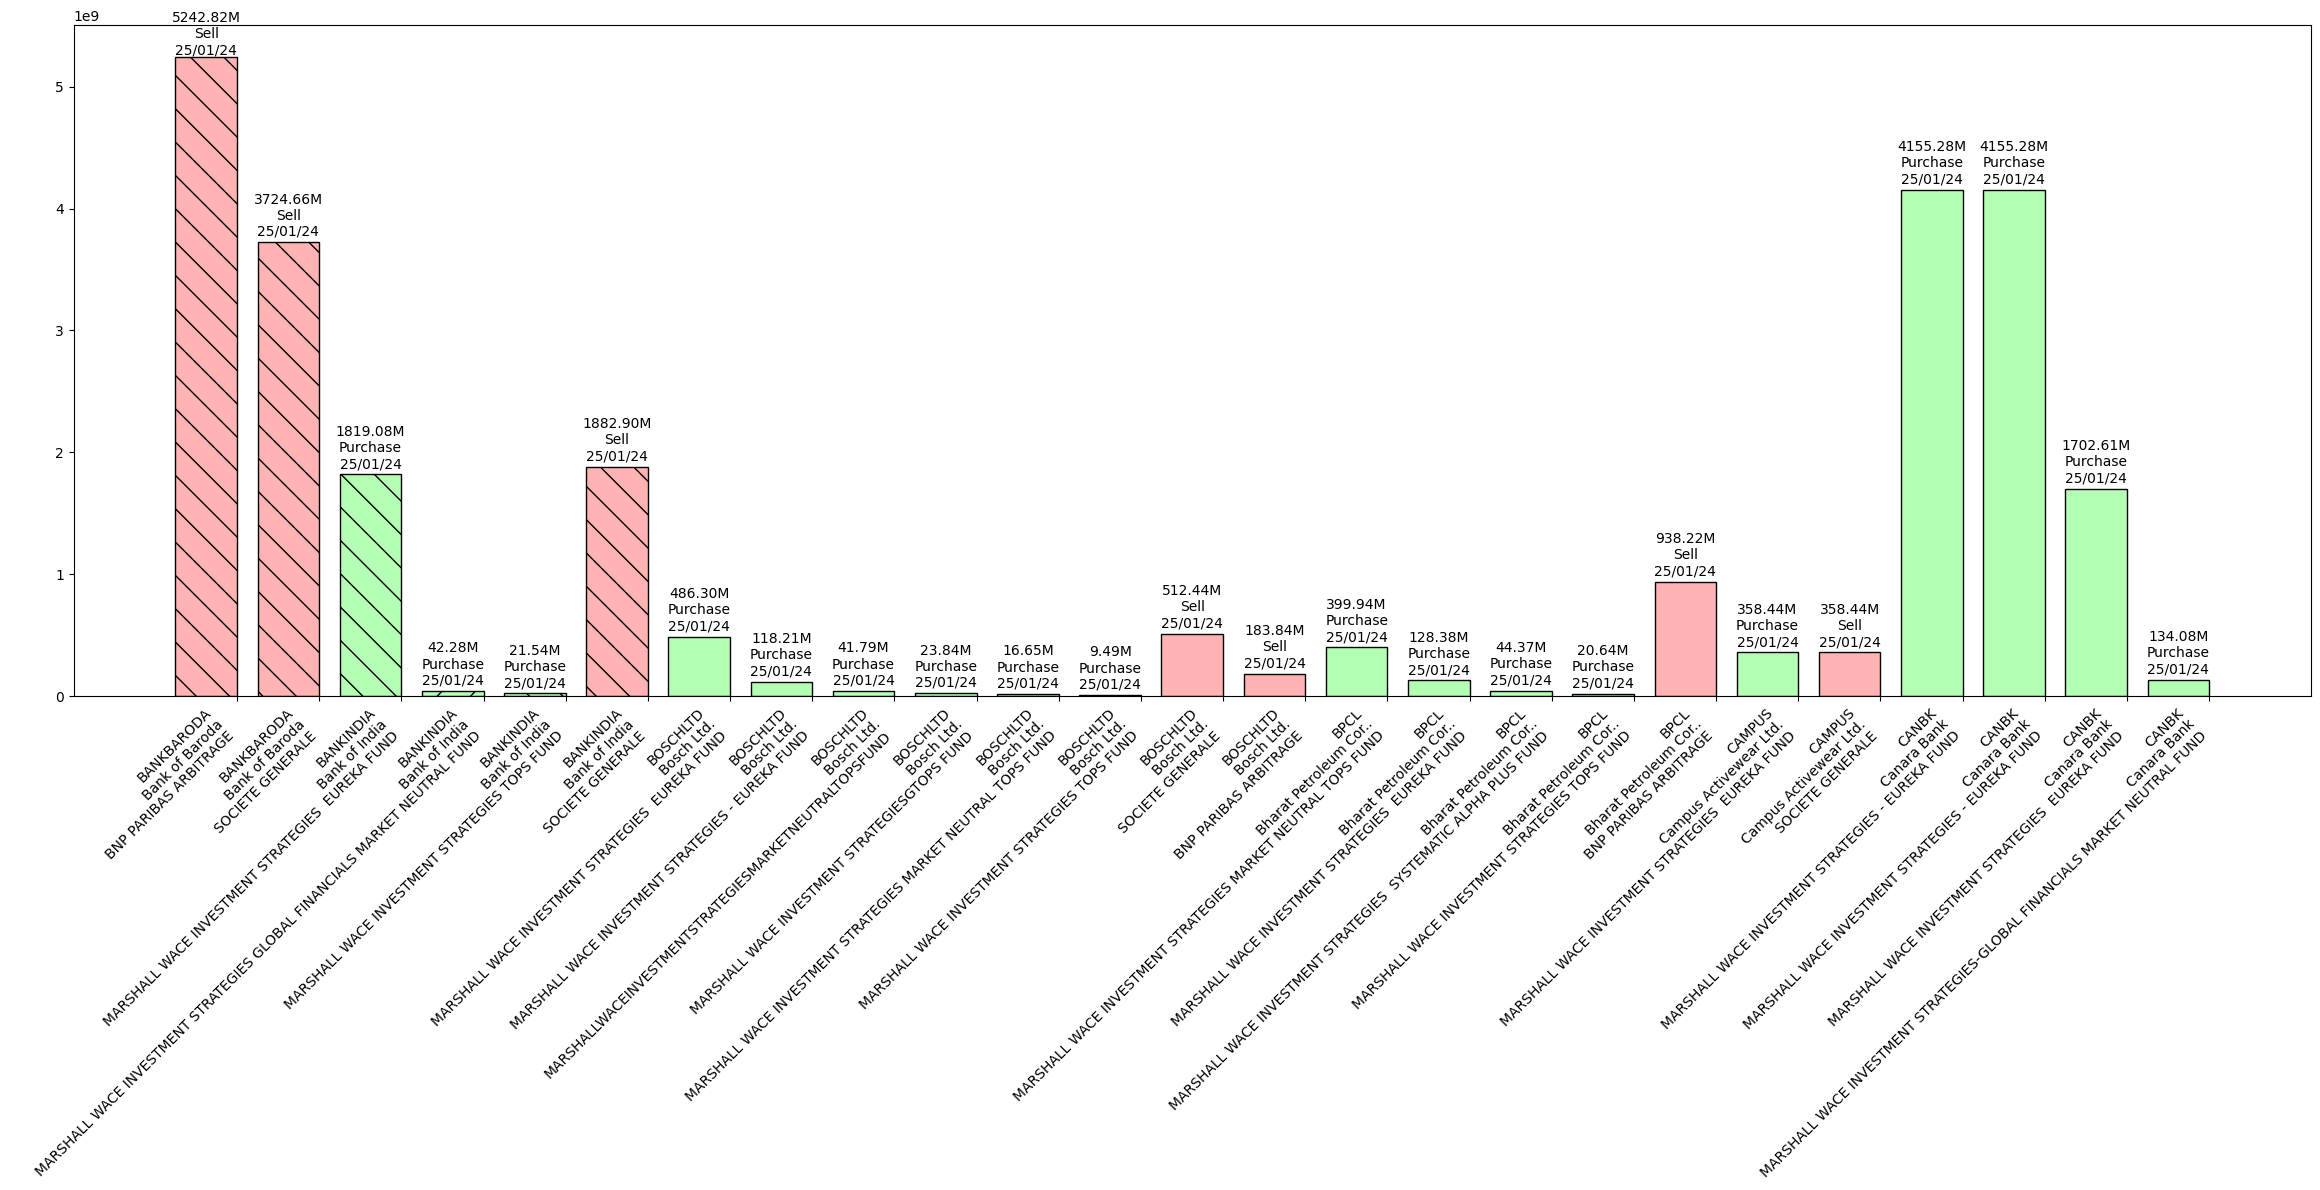

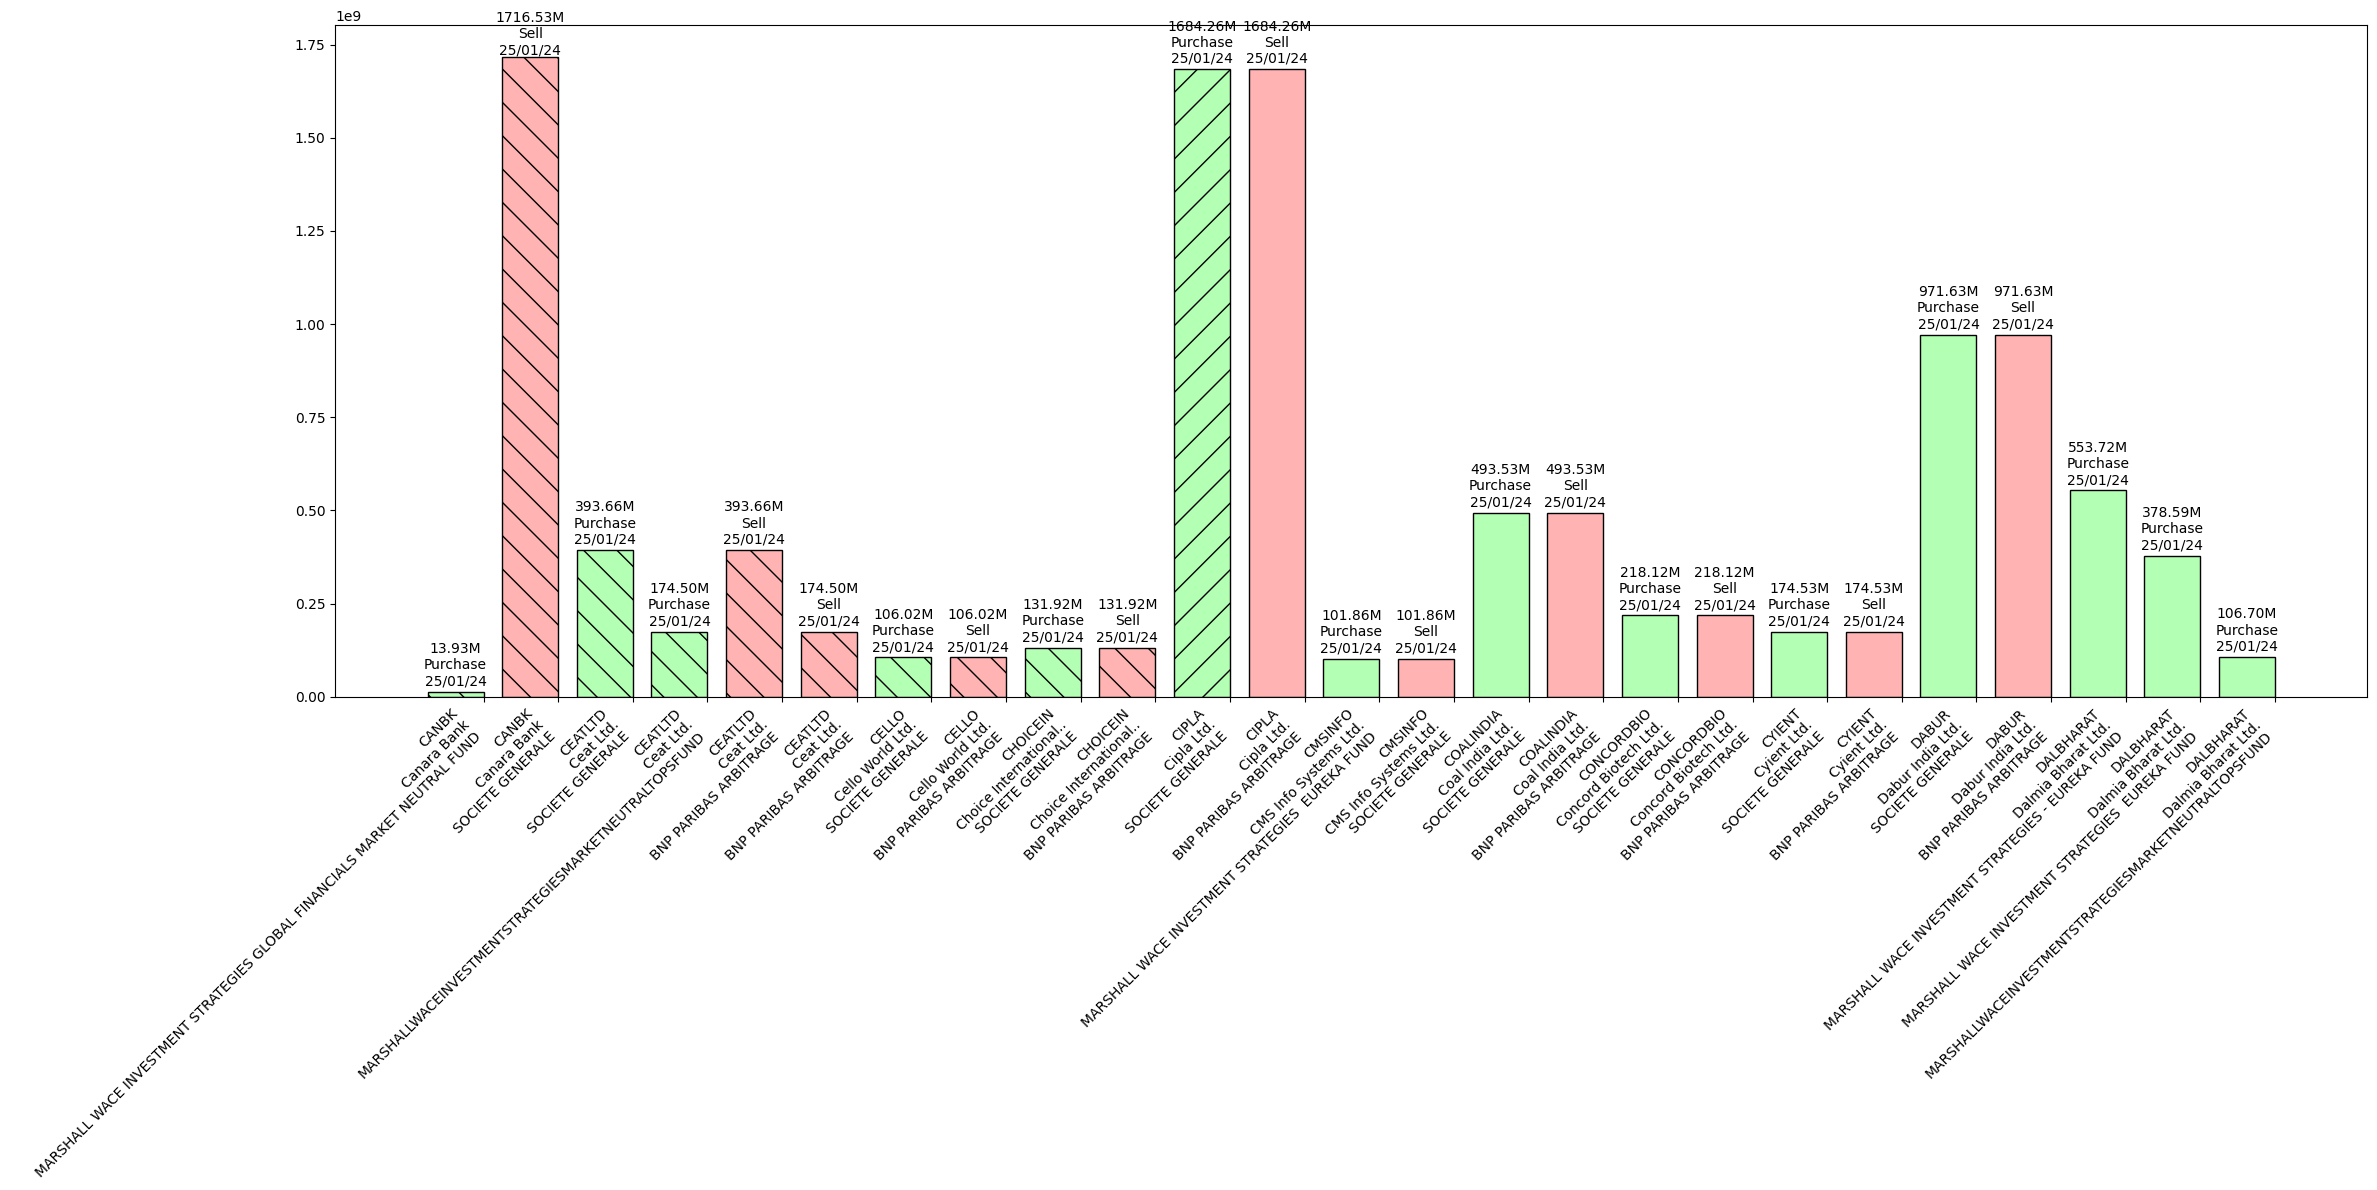

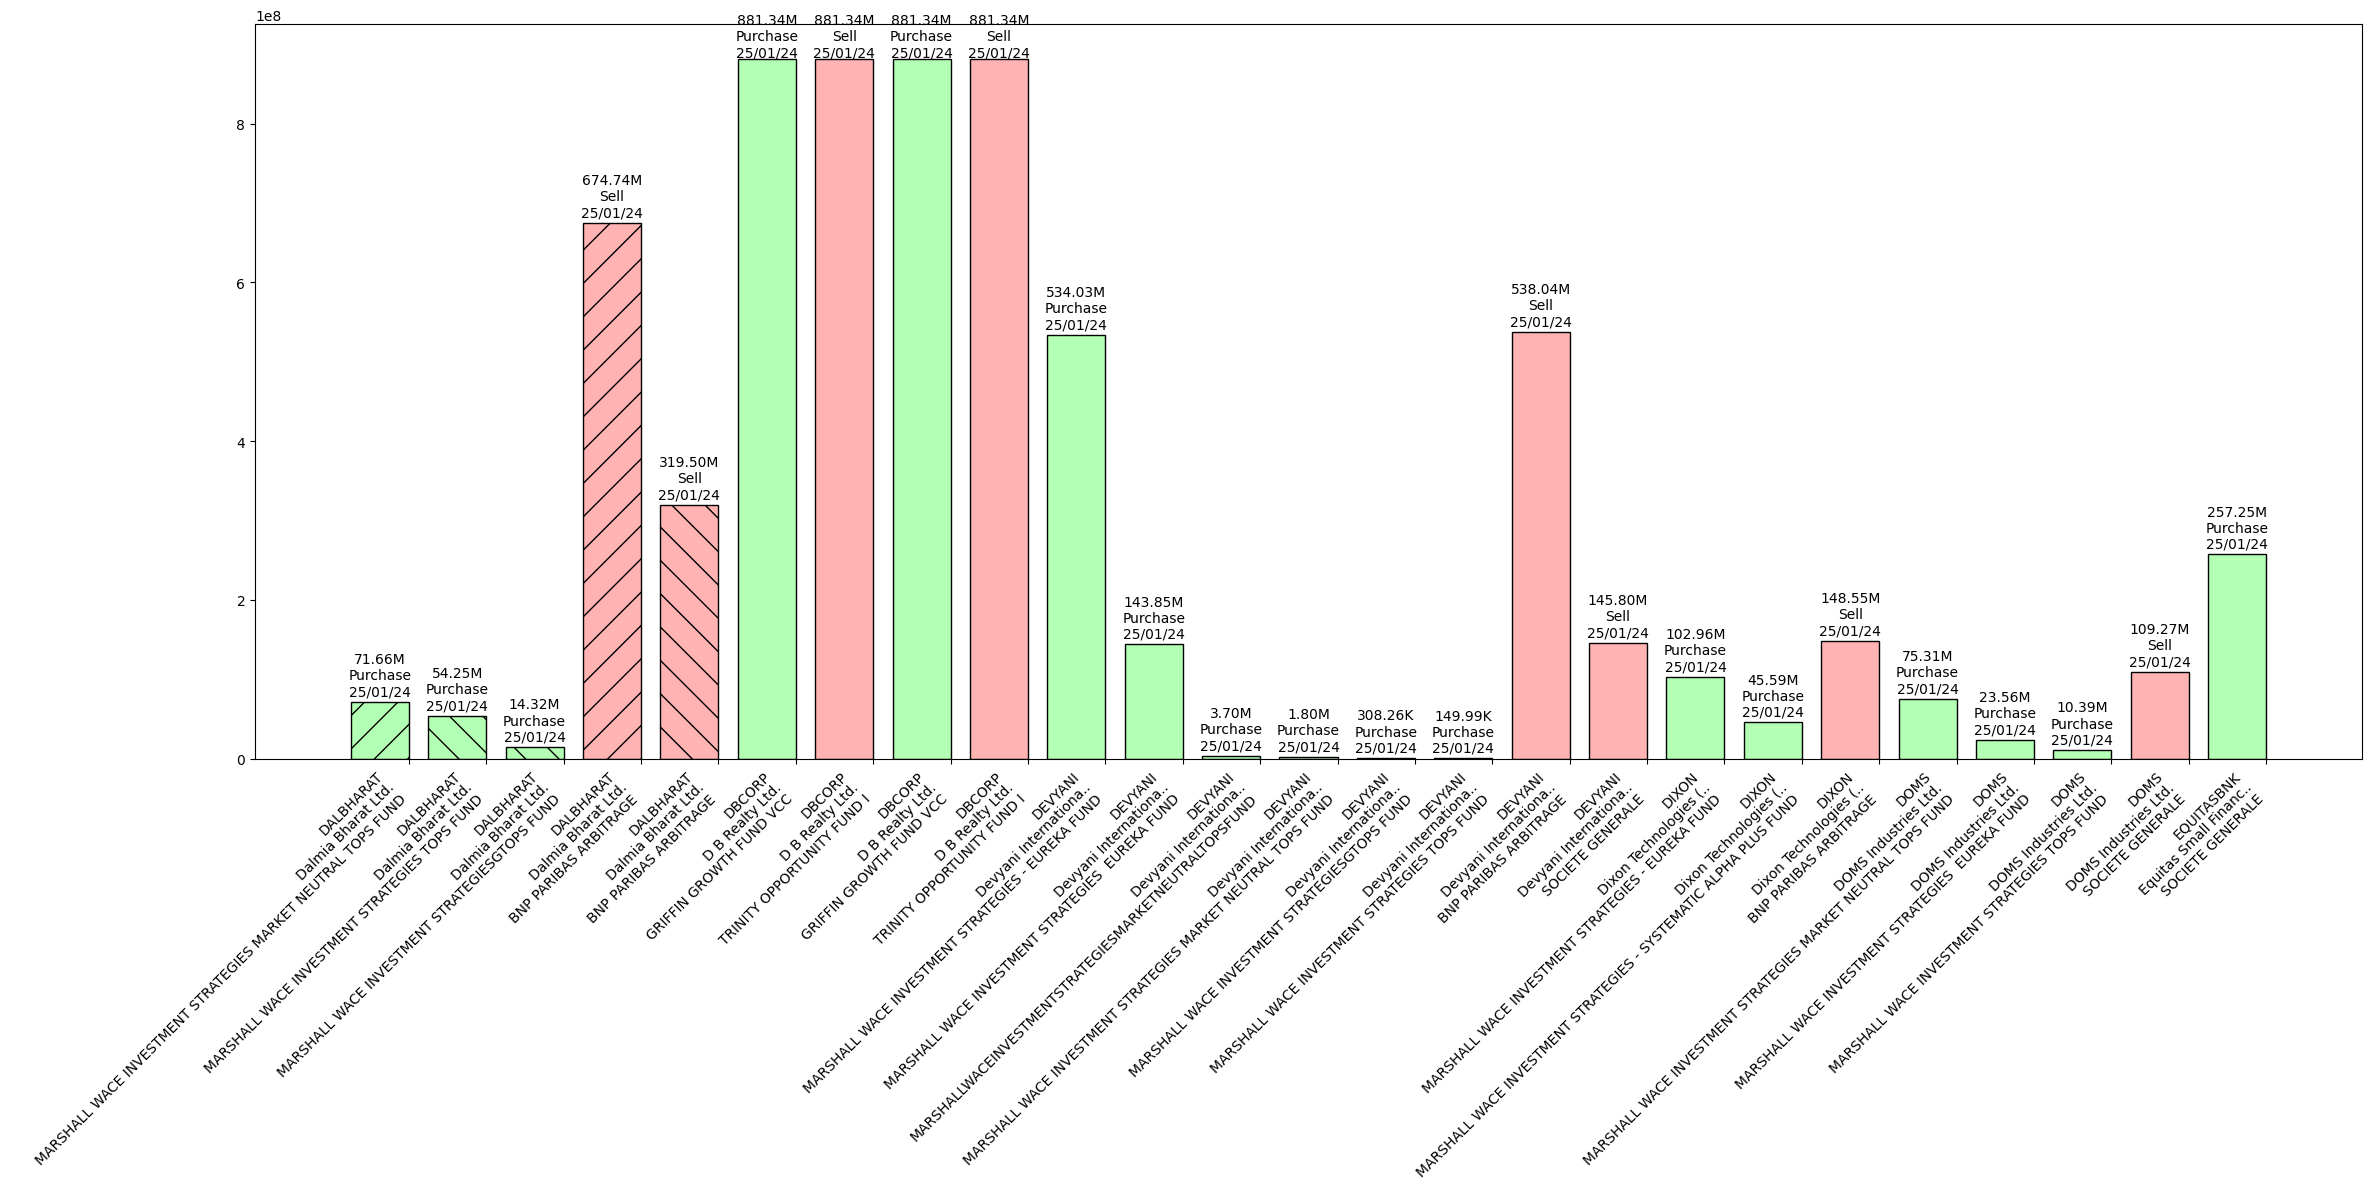

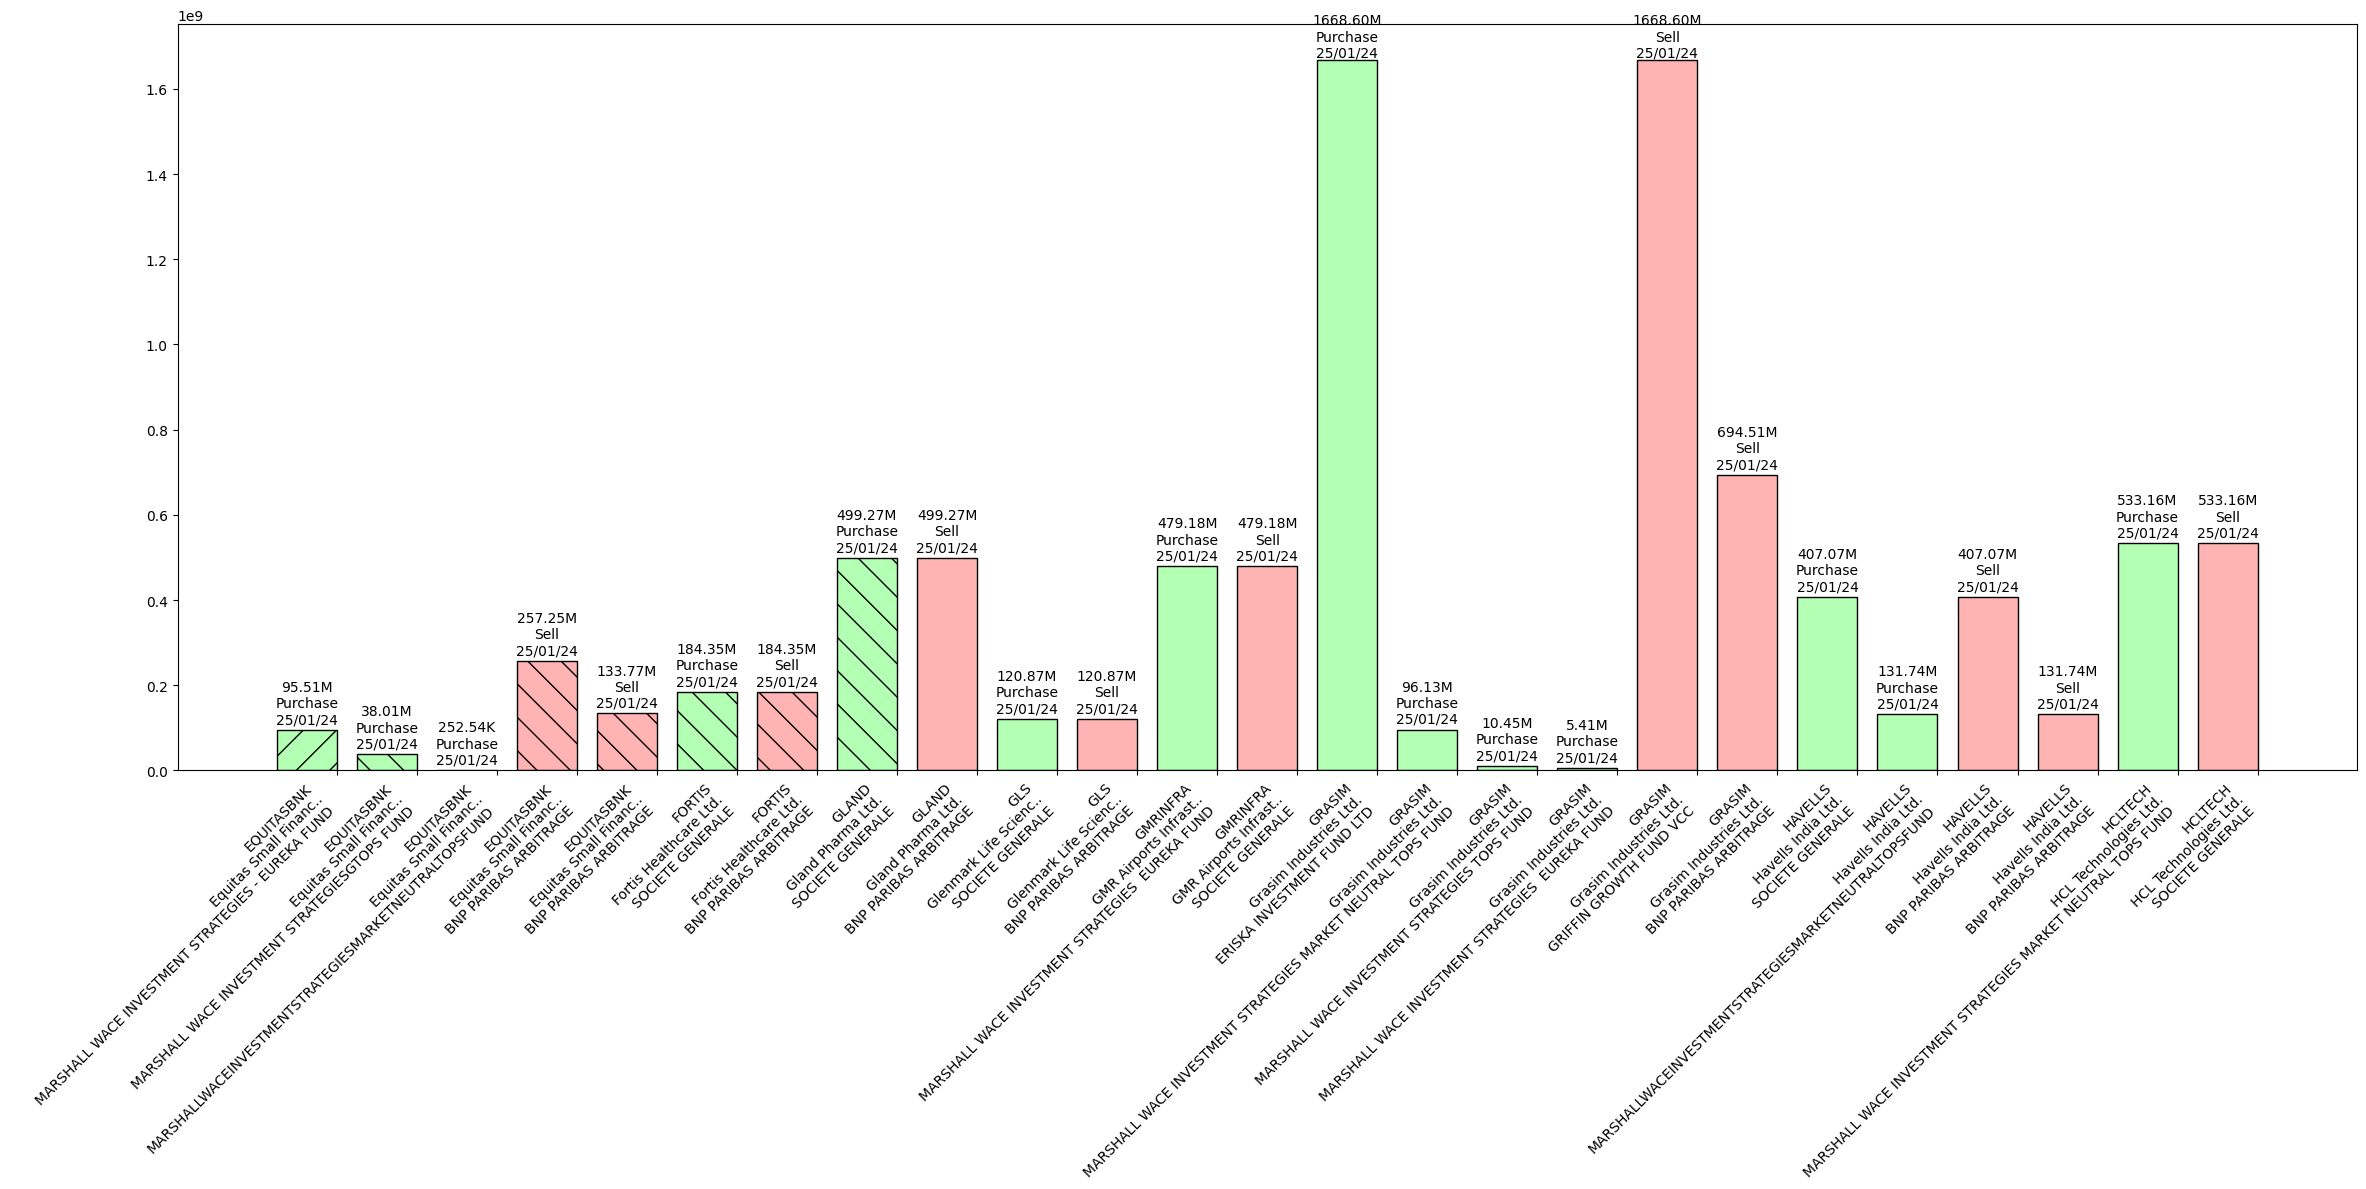

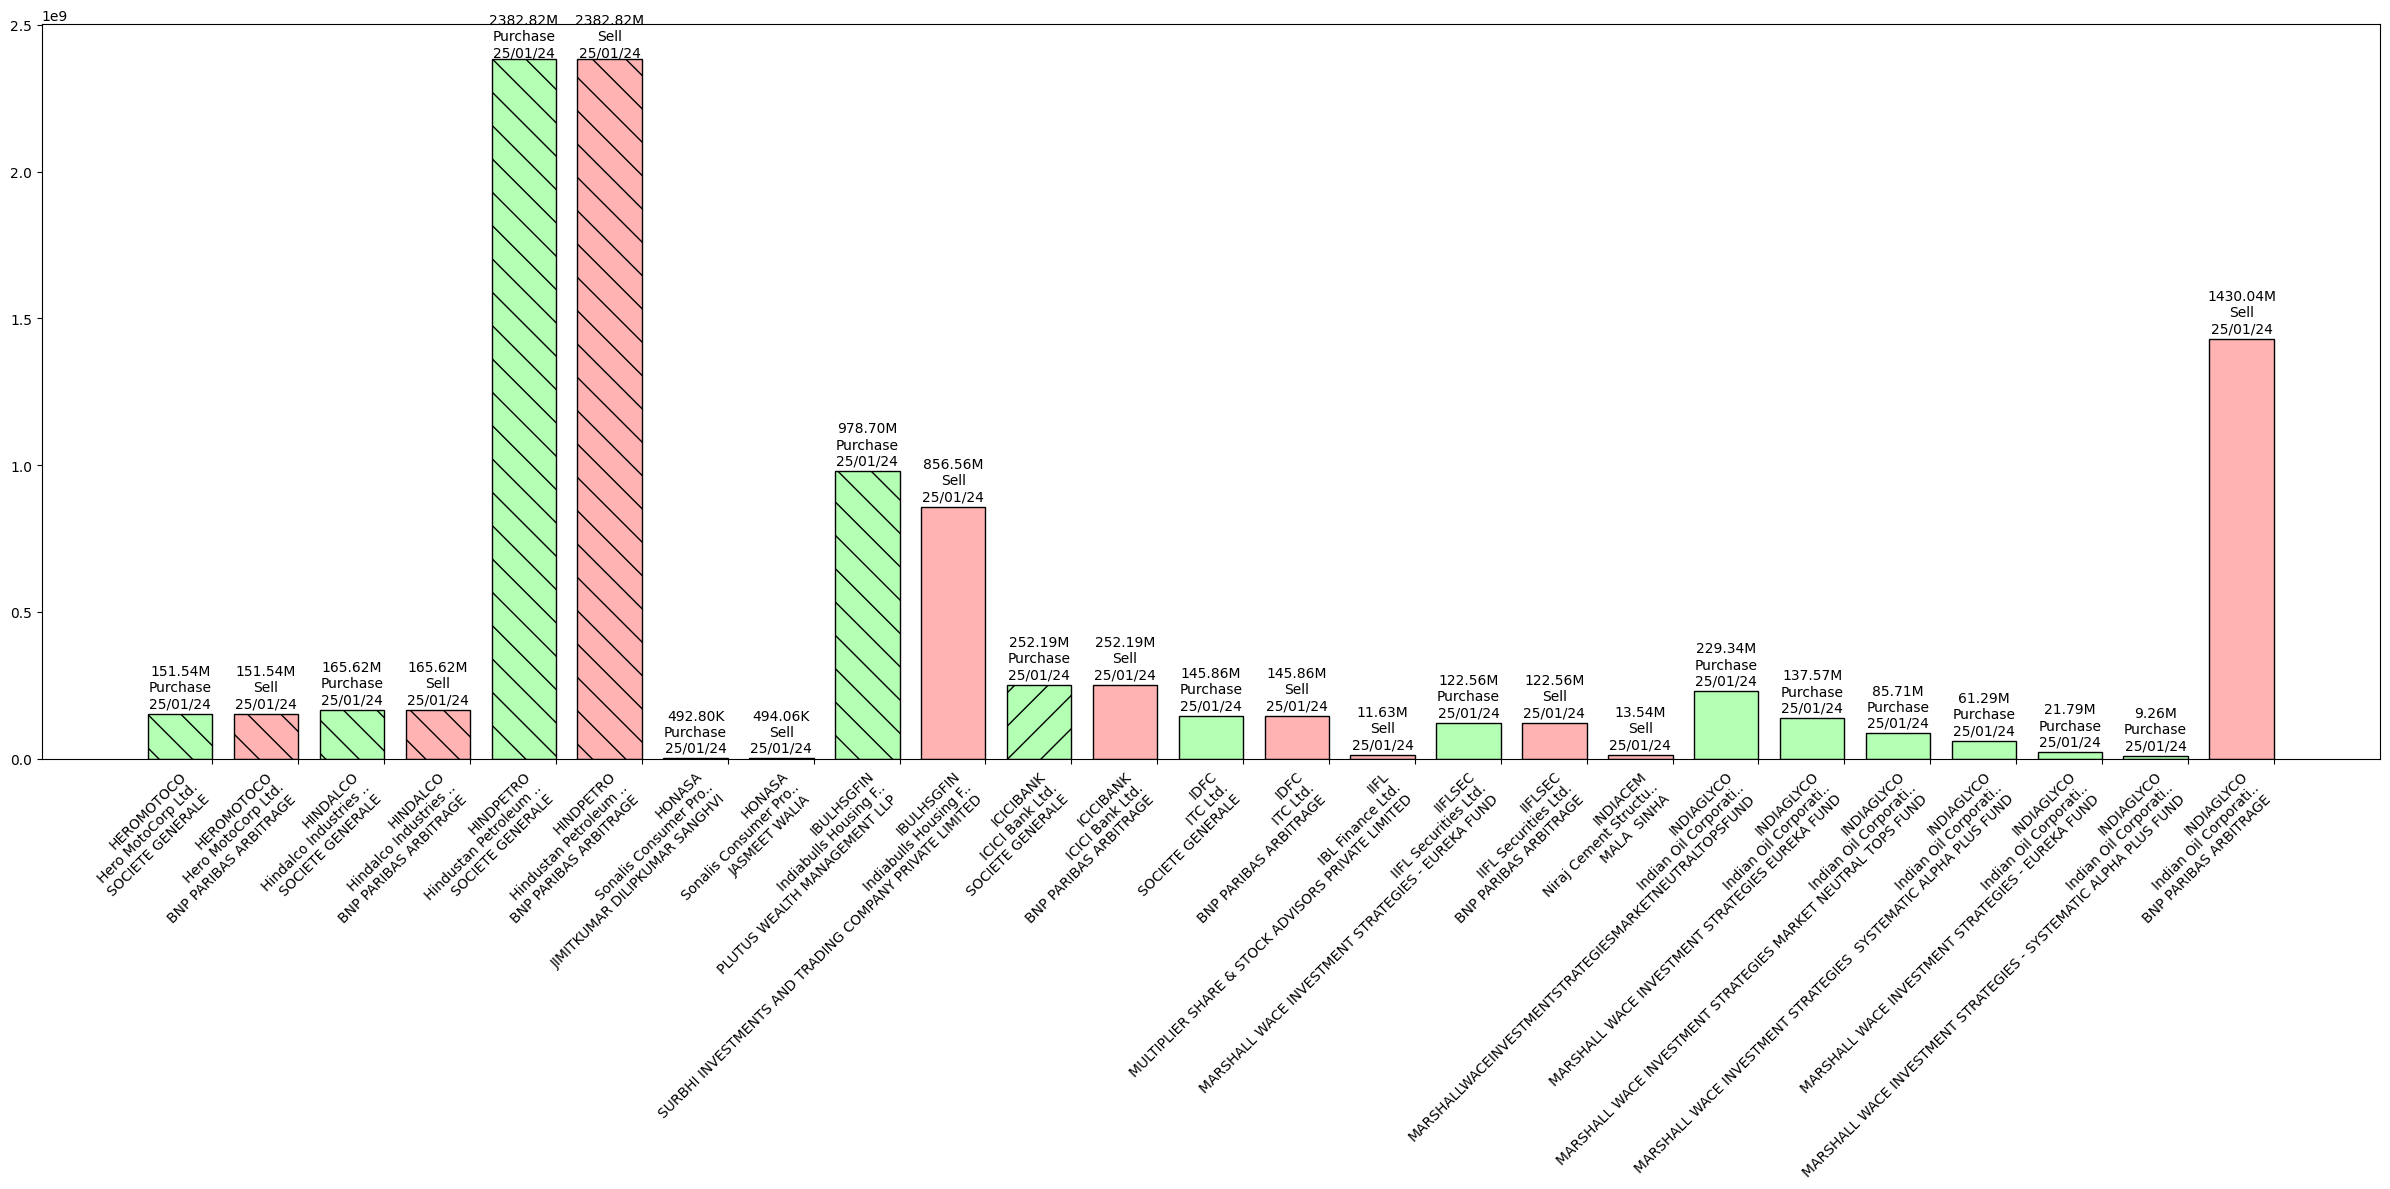

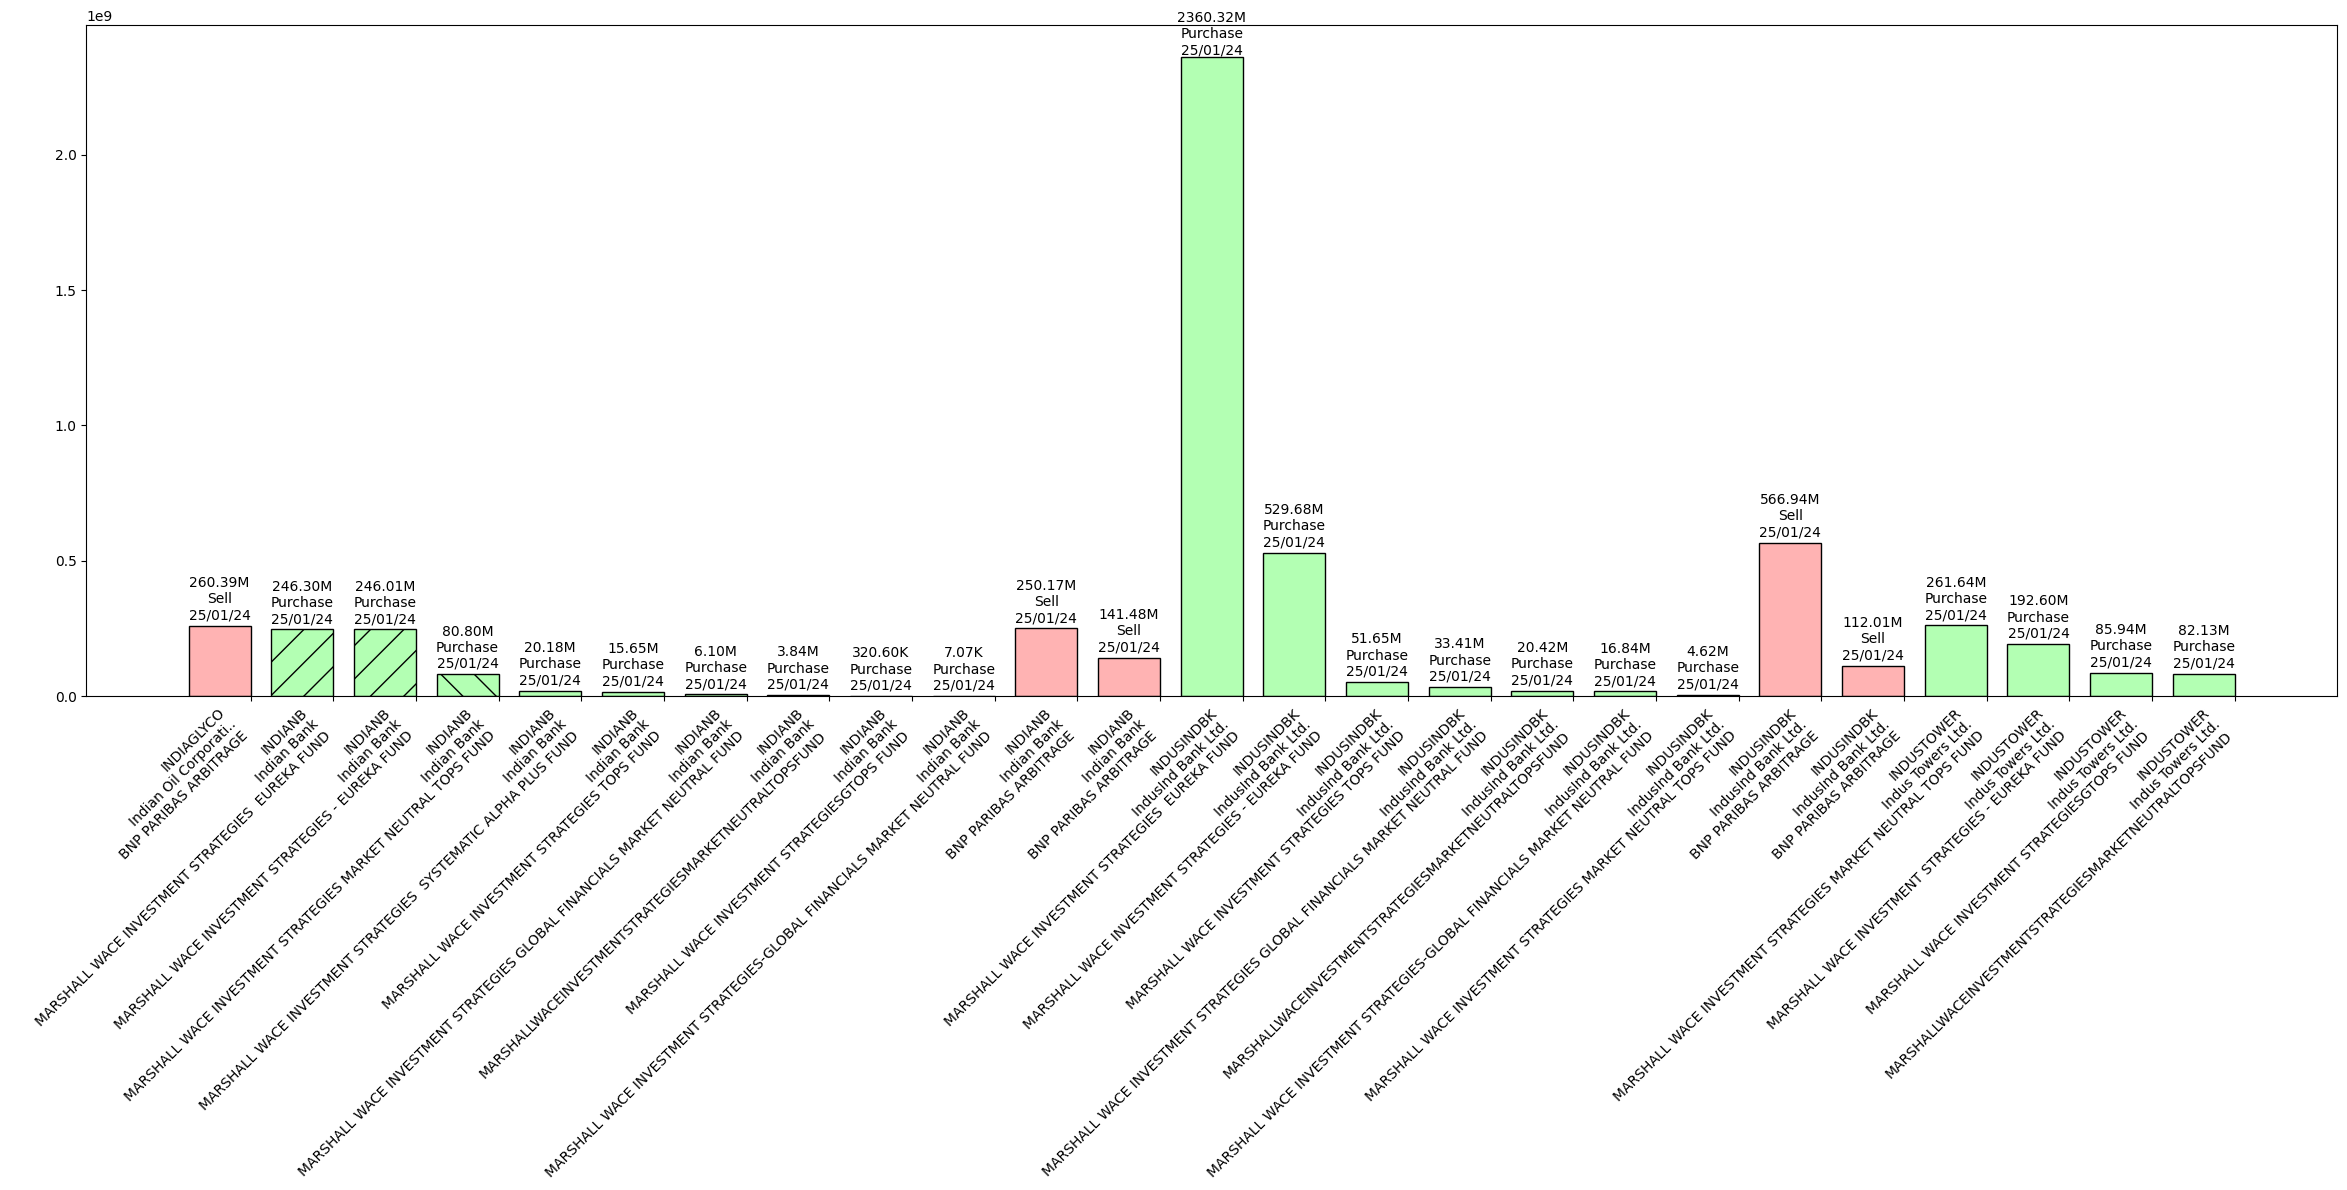

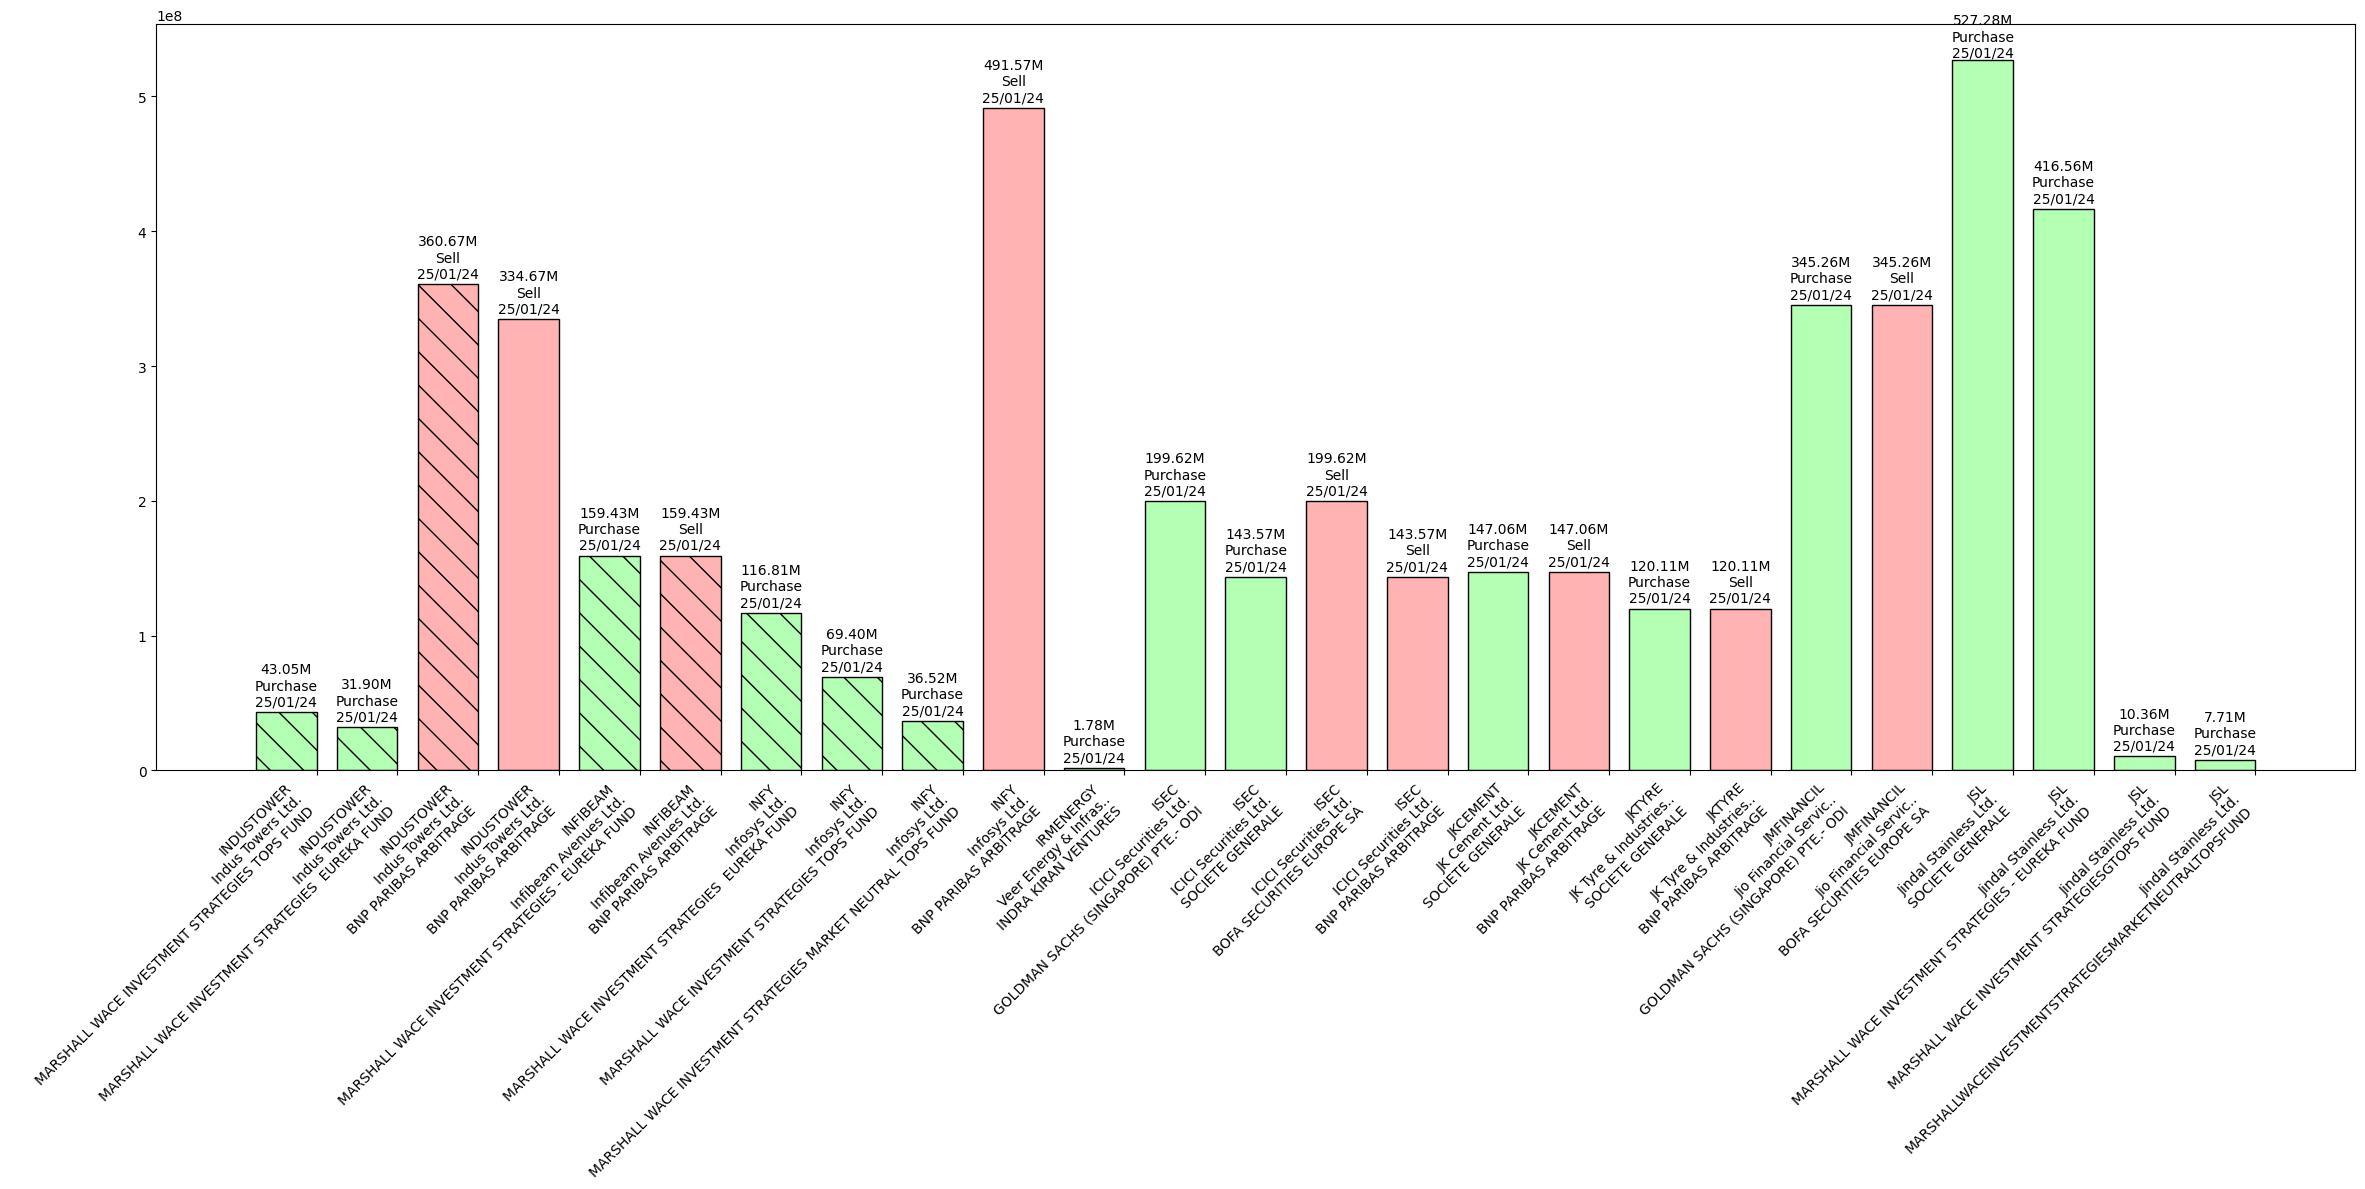


Special Clients:
Only Buy or Sell:


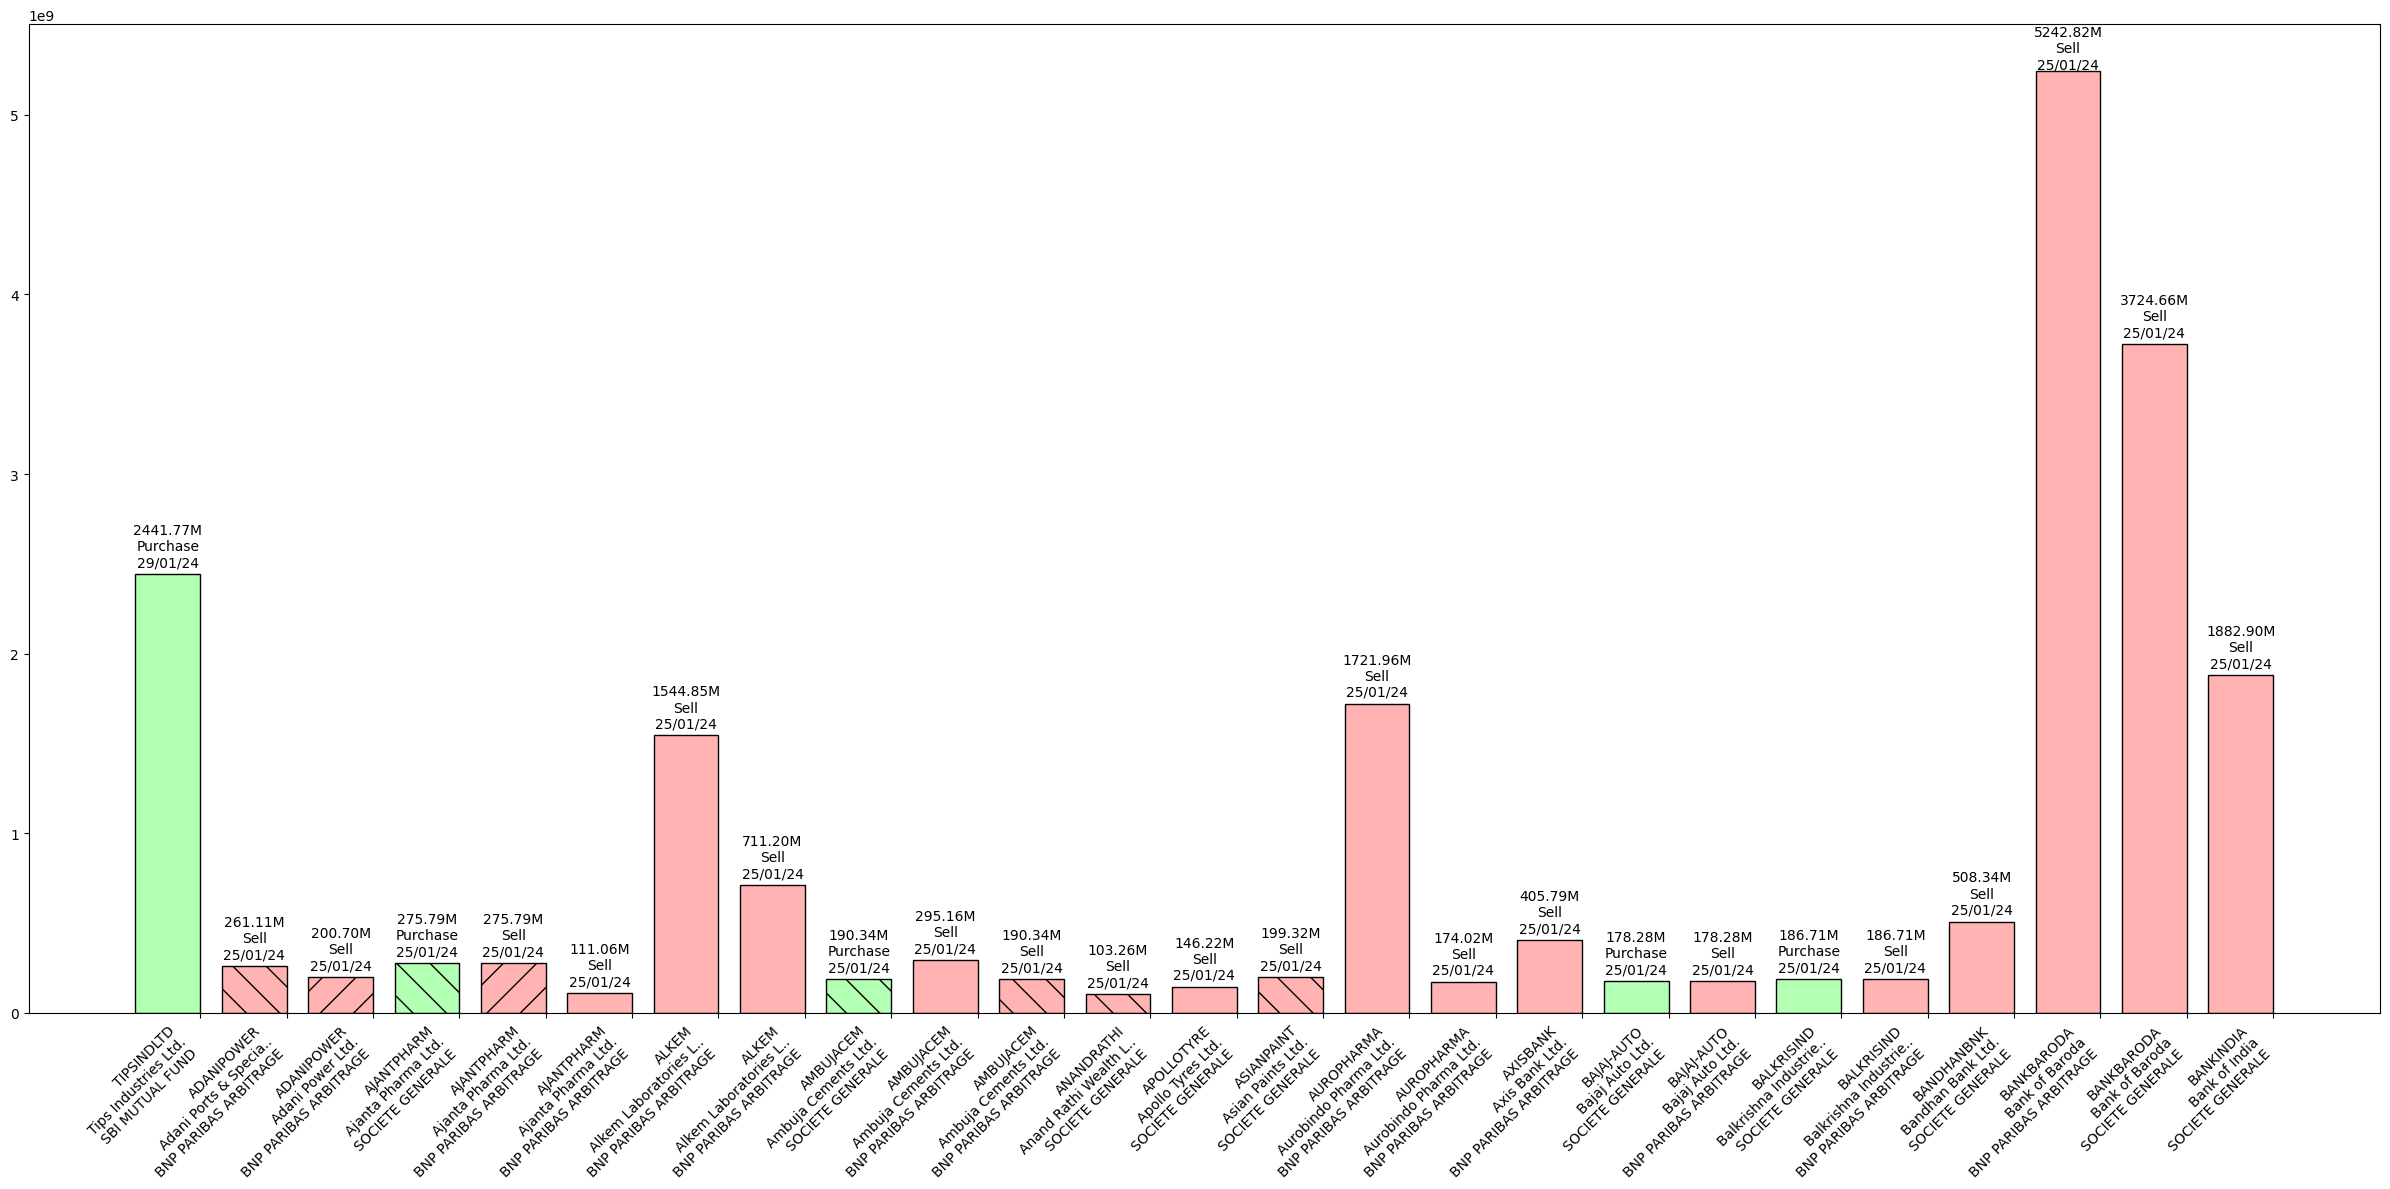

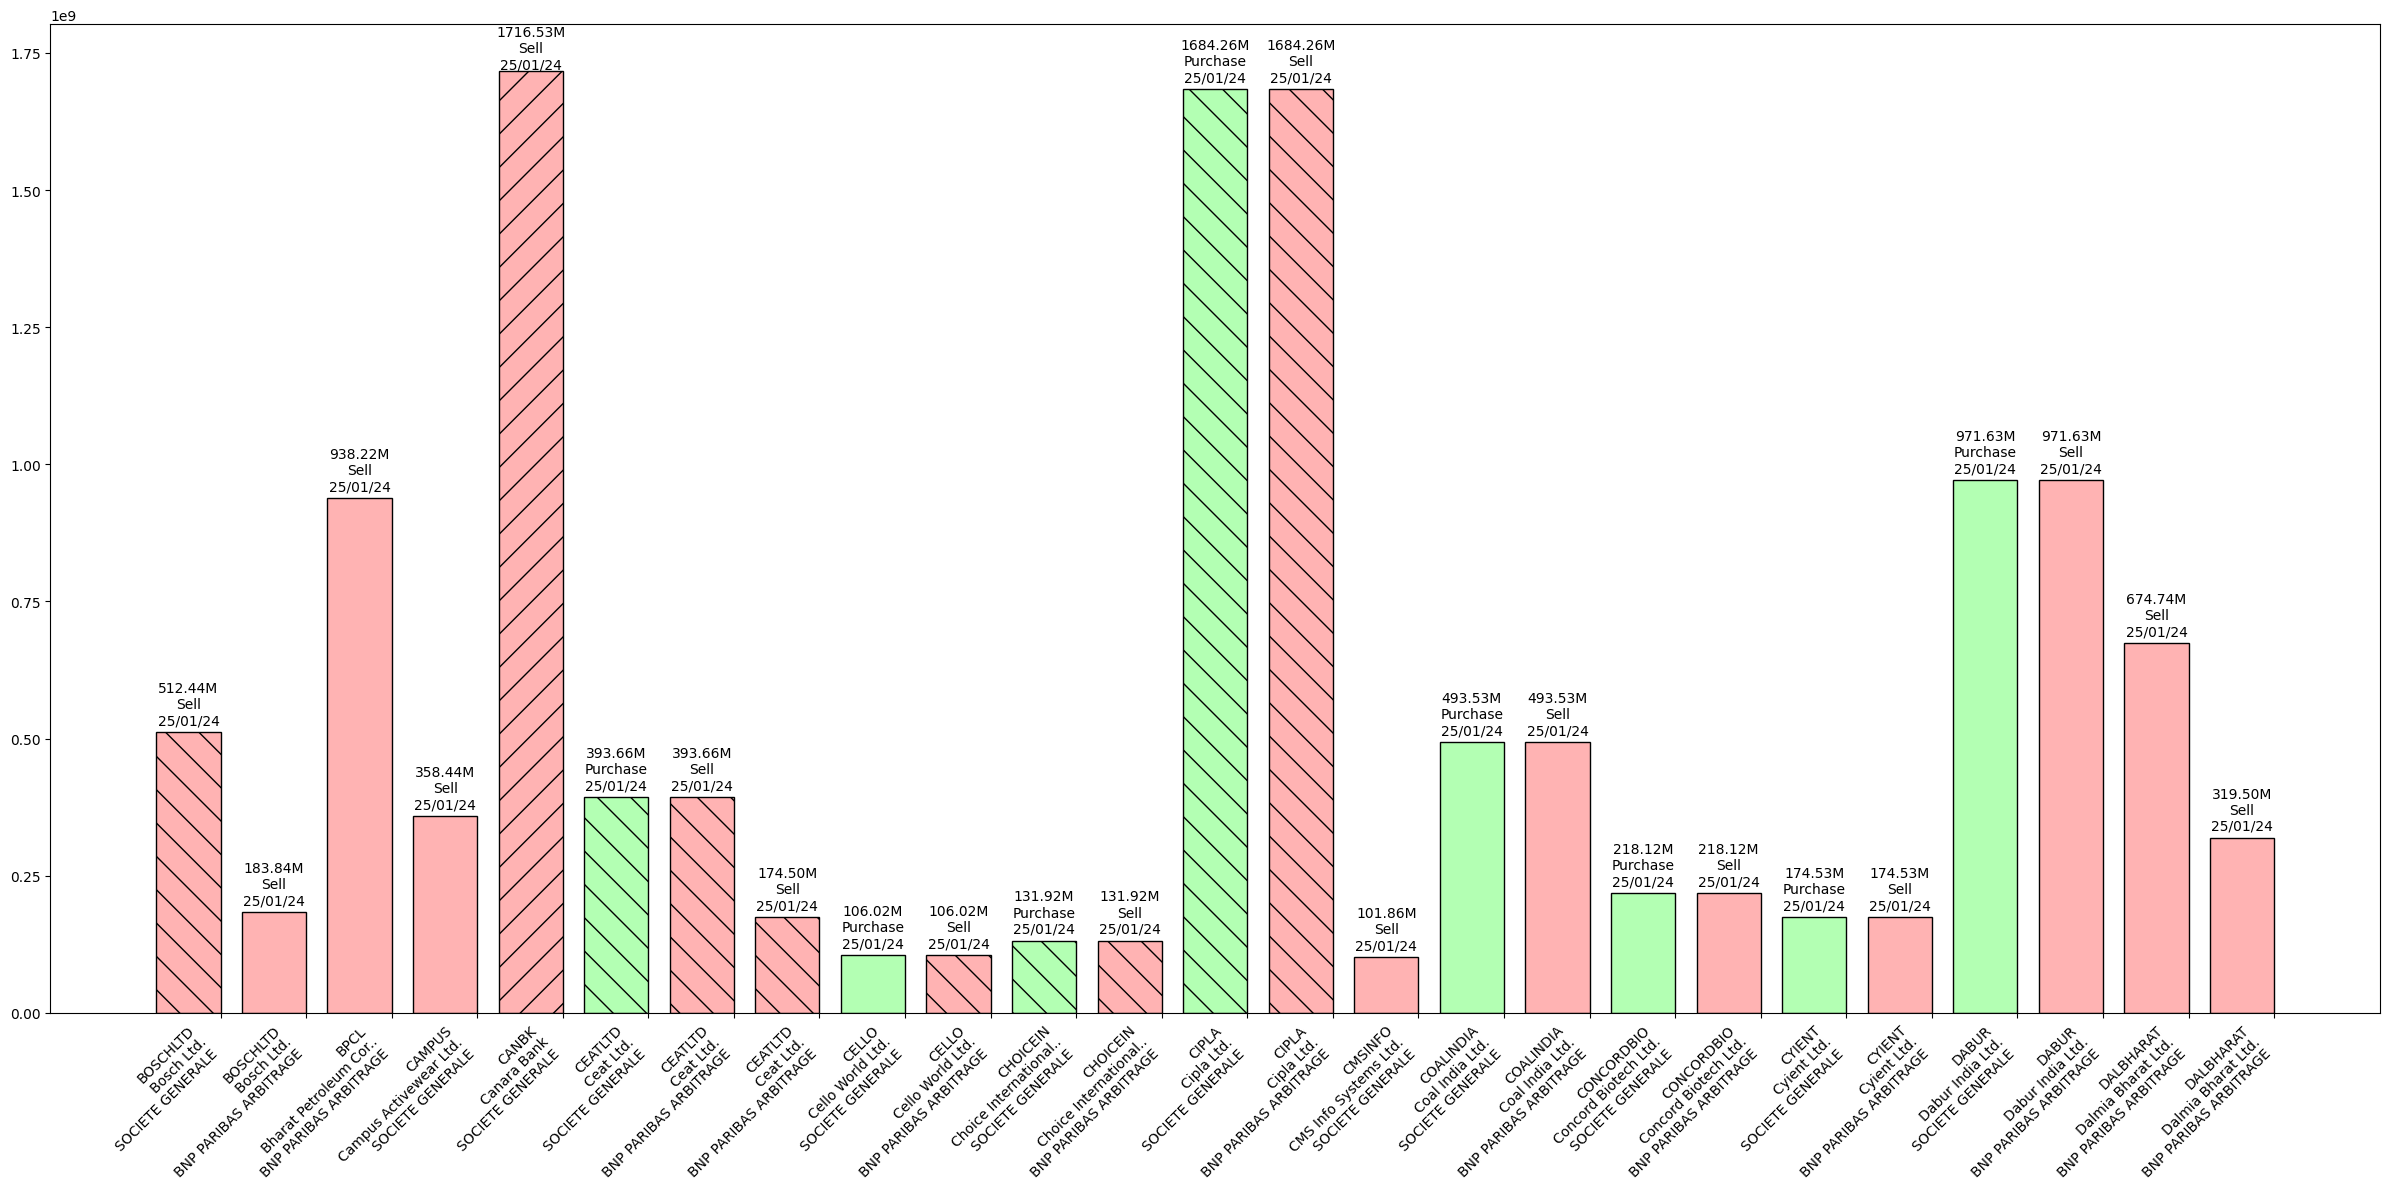

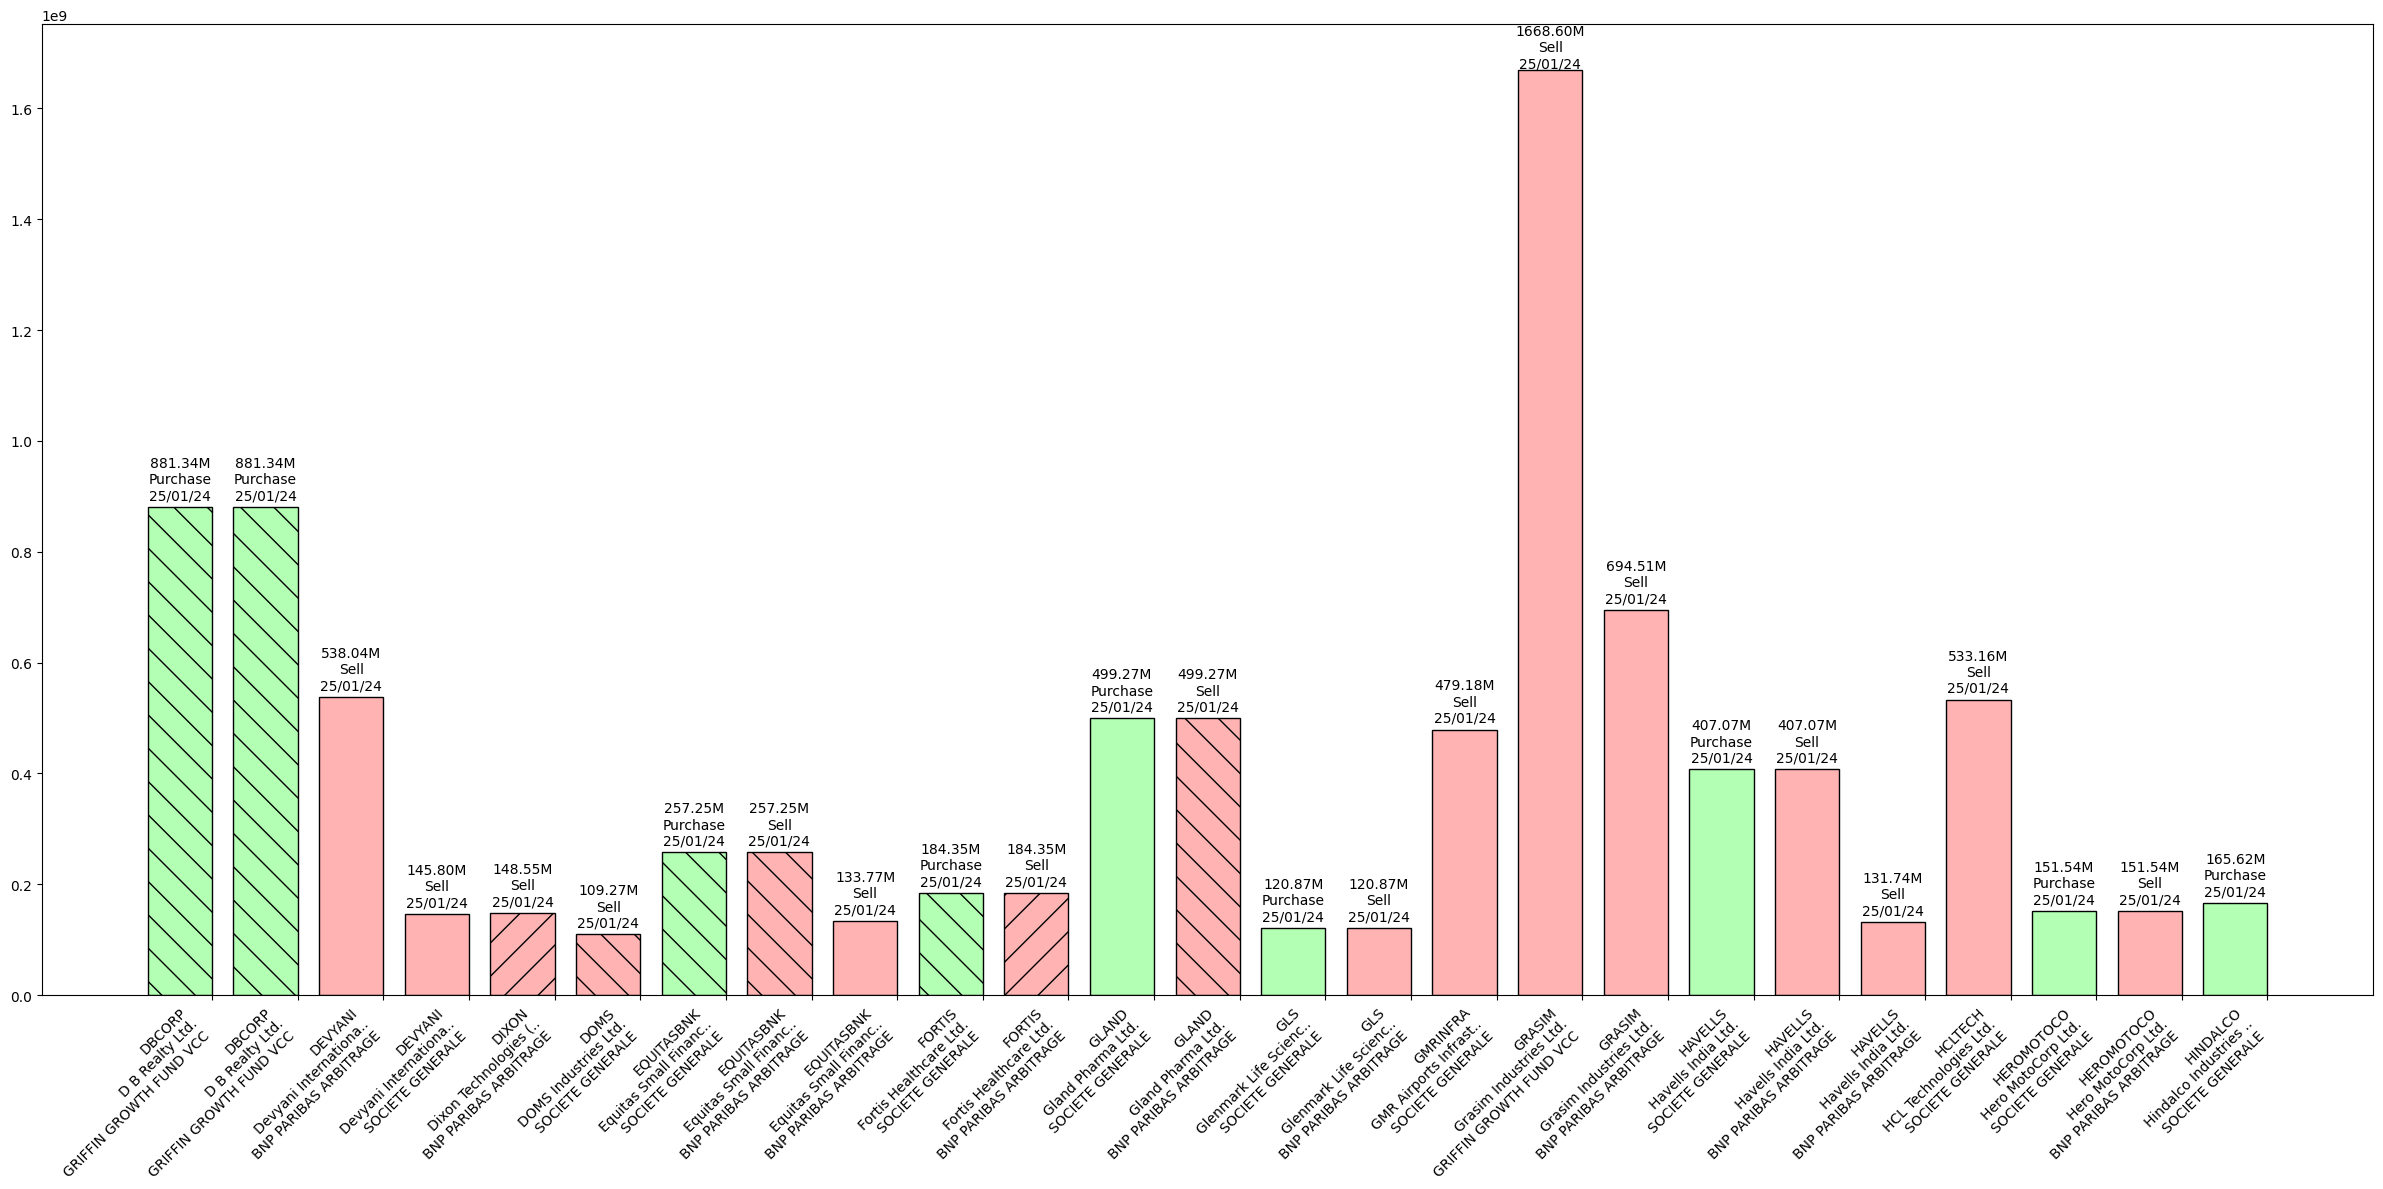

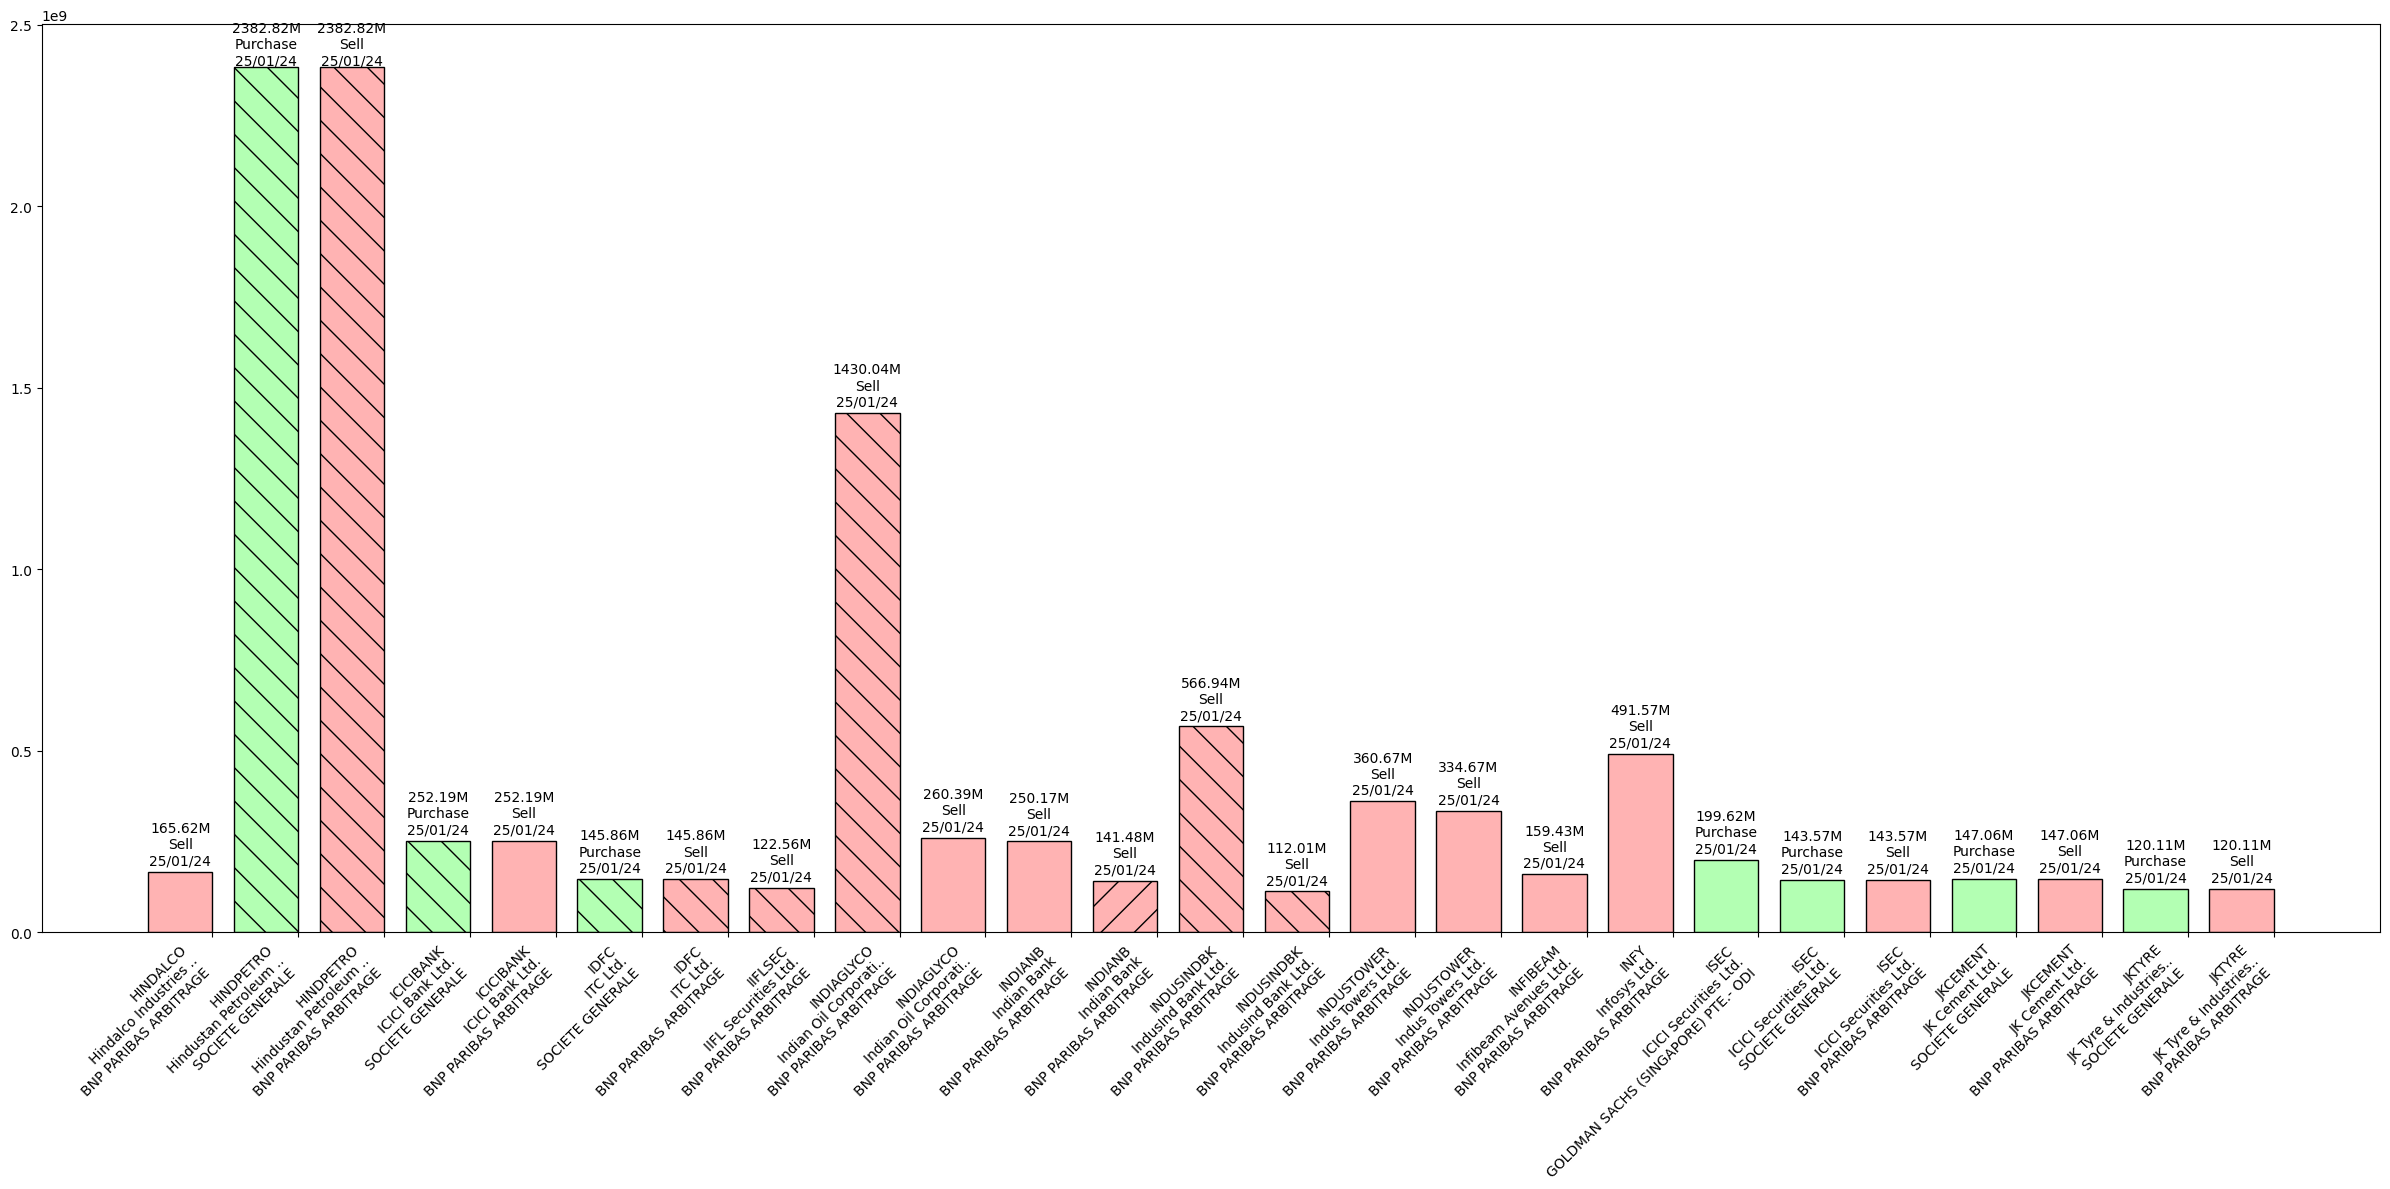

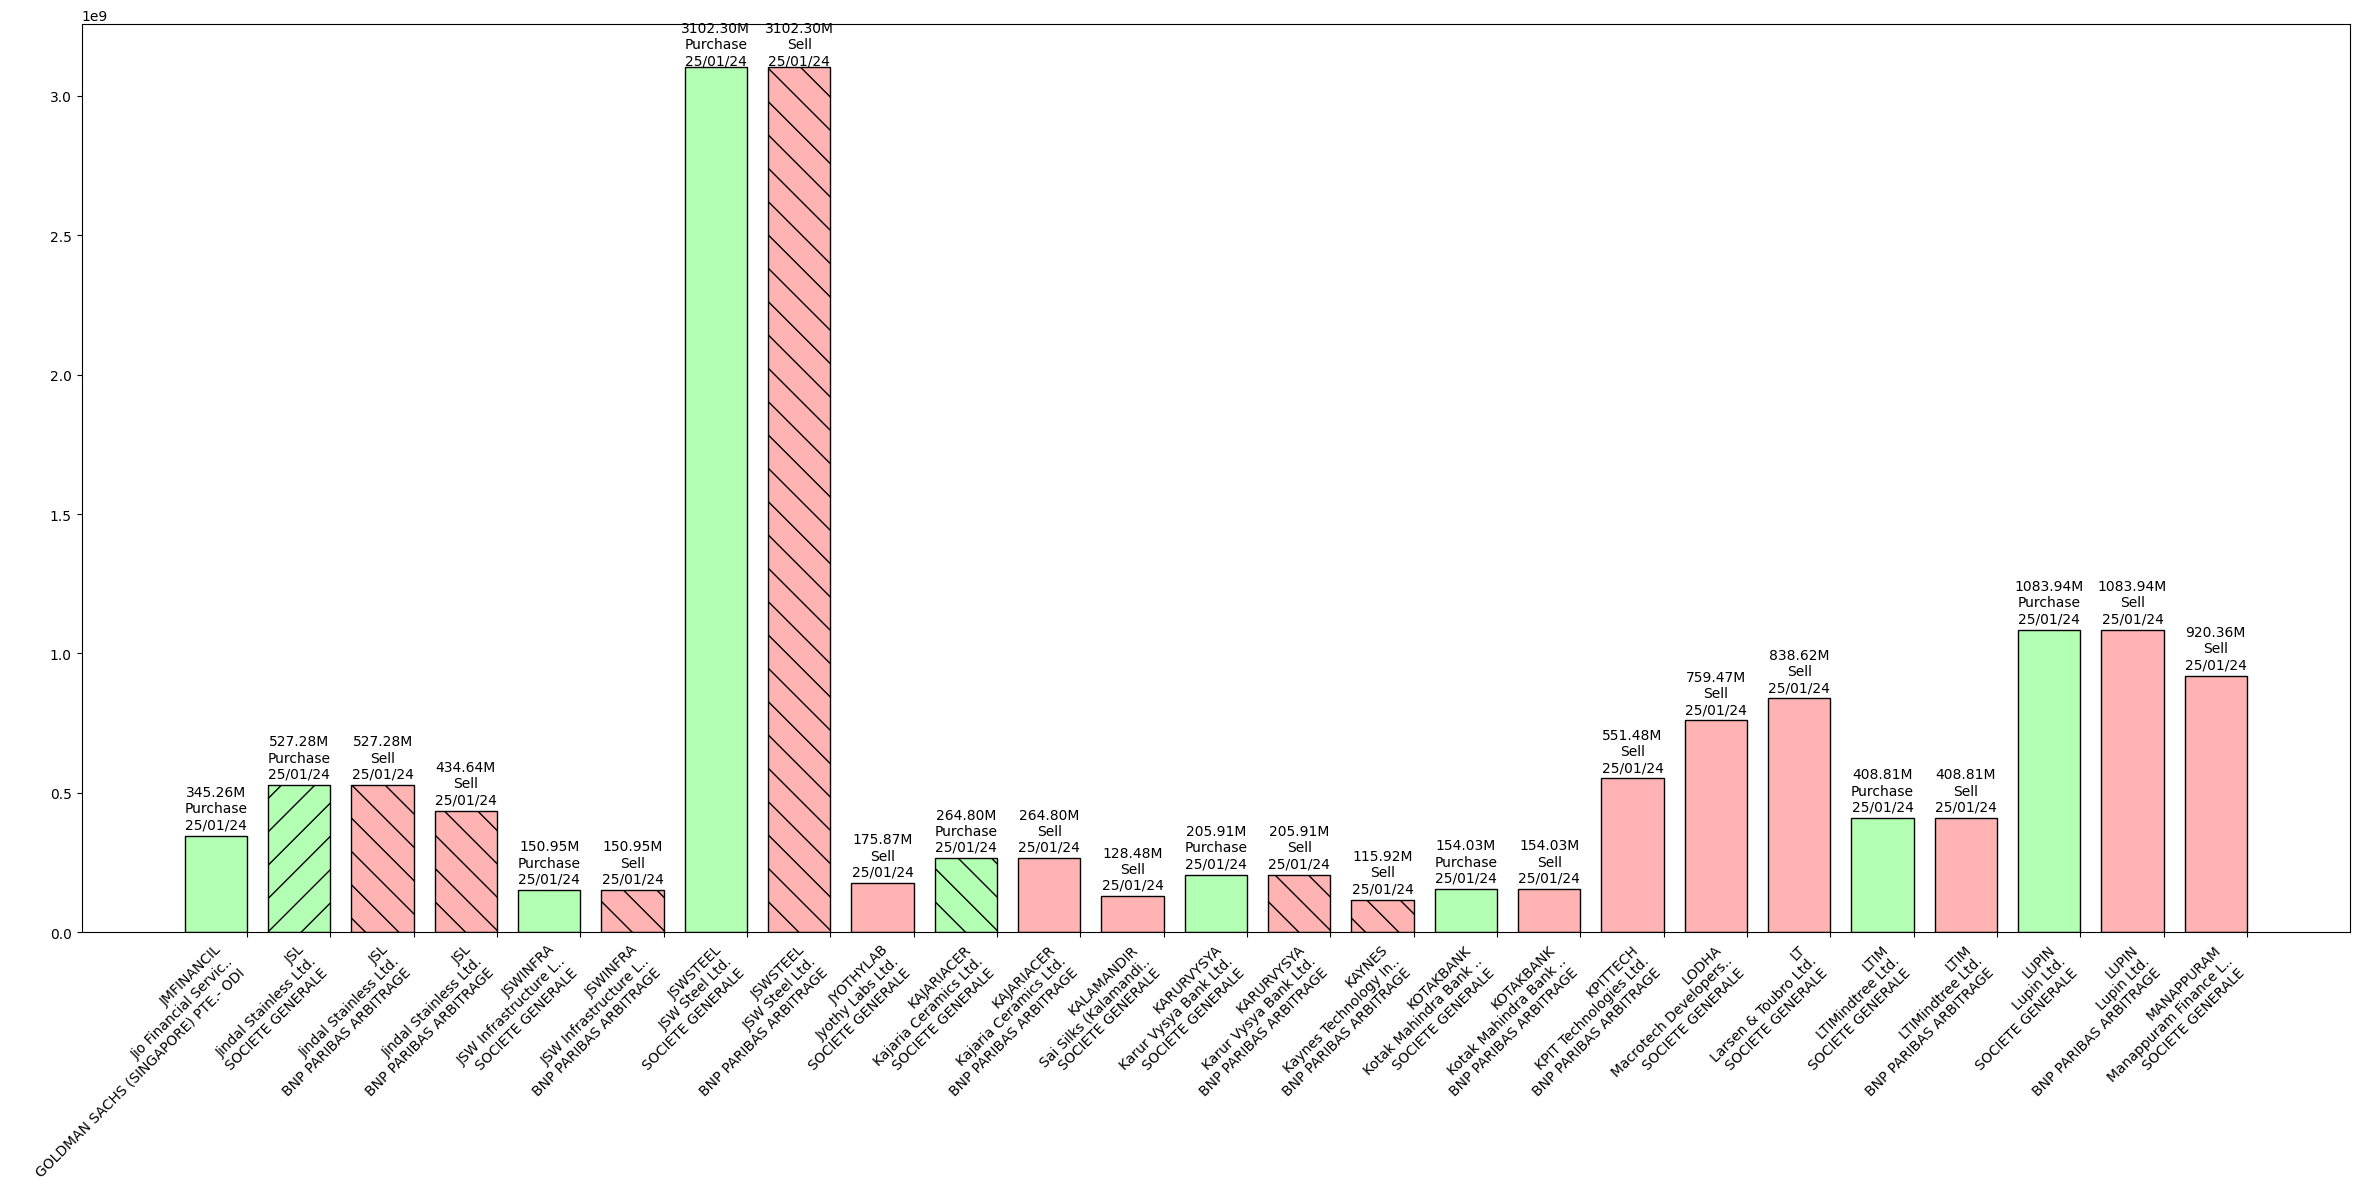

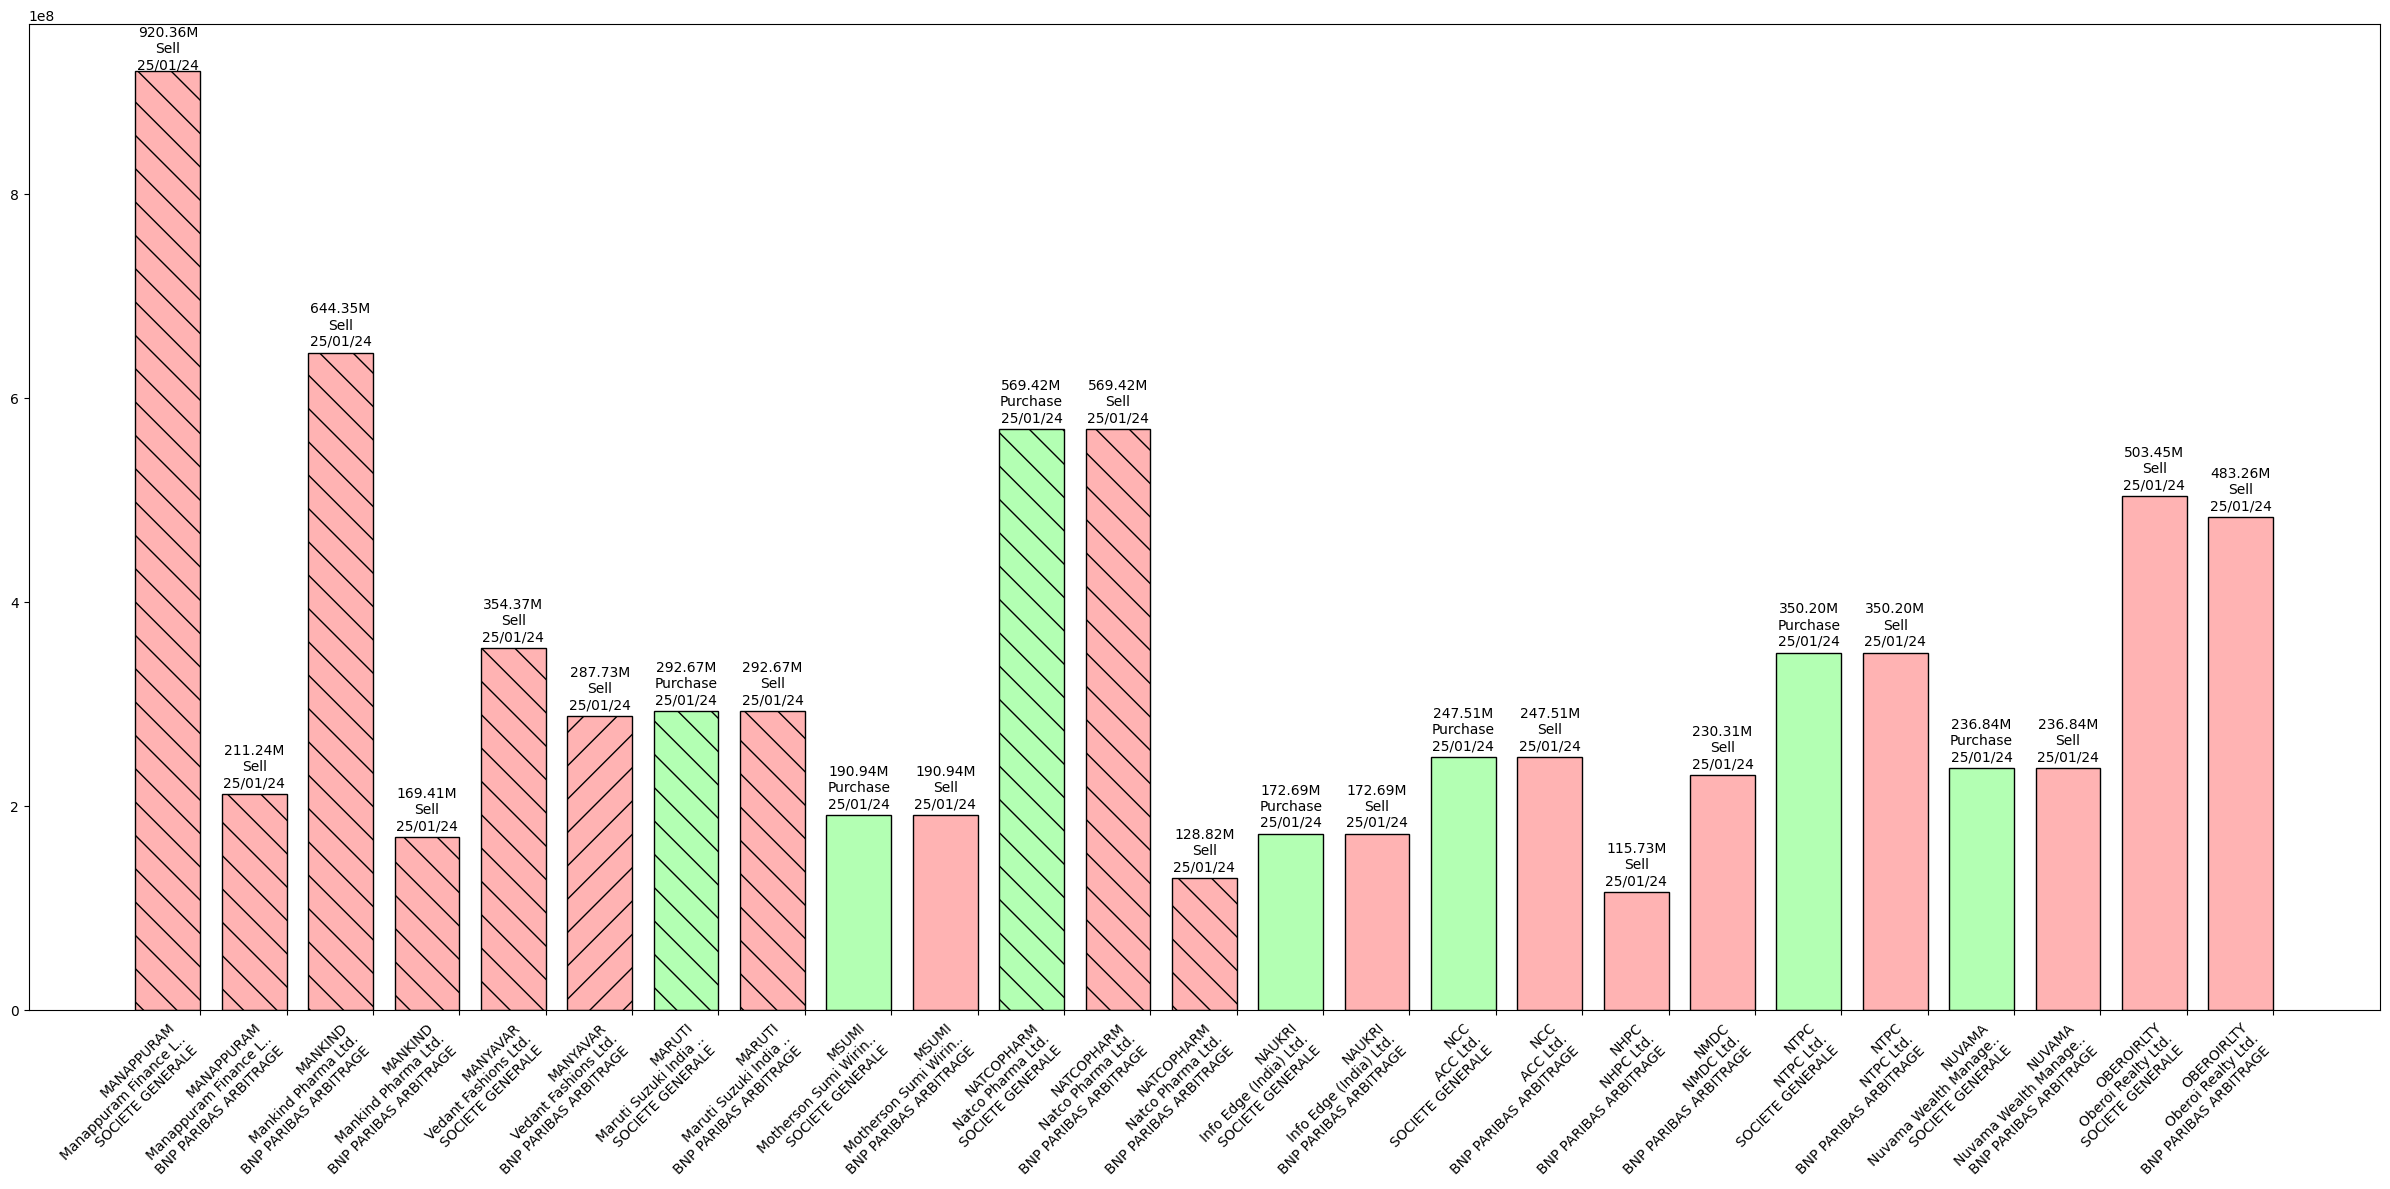

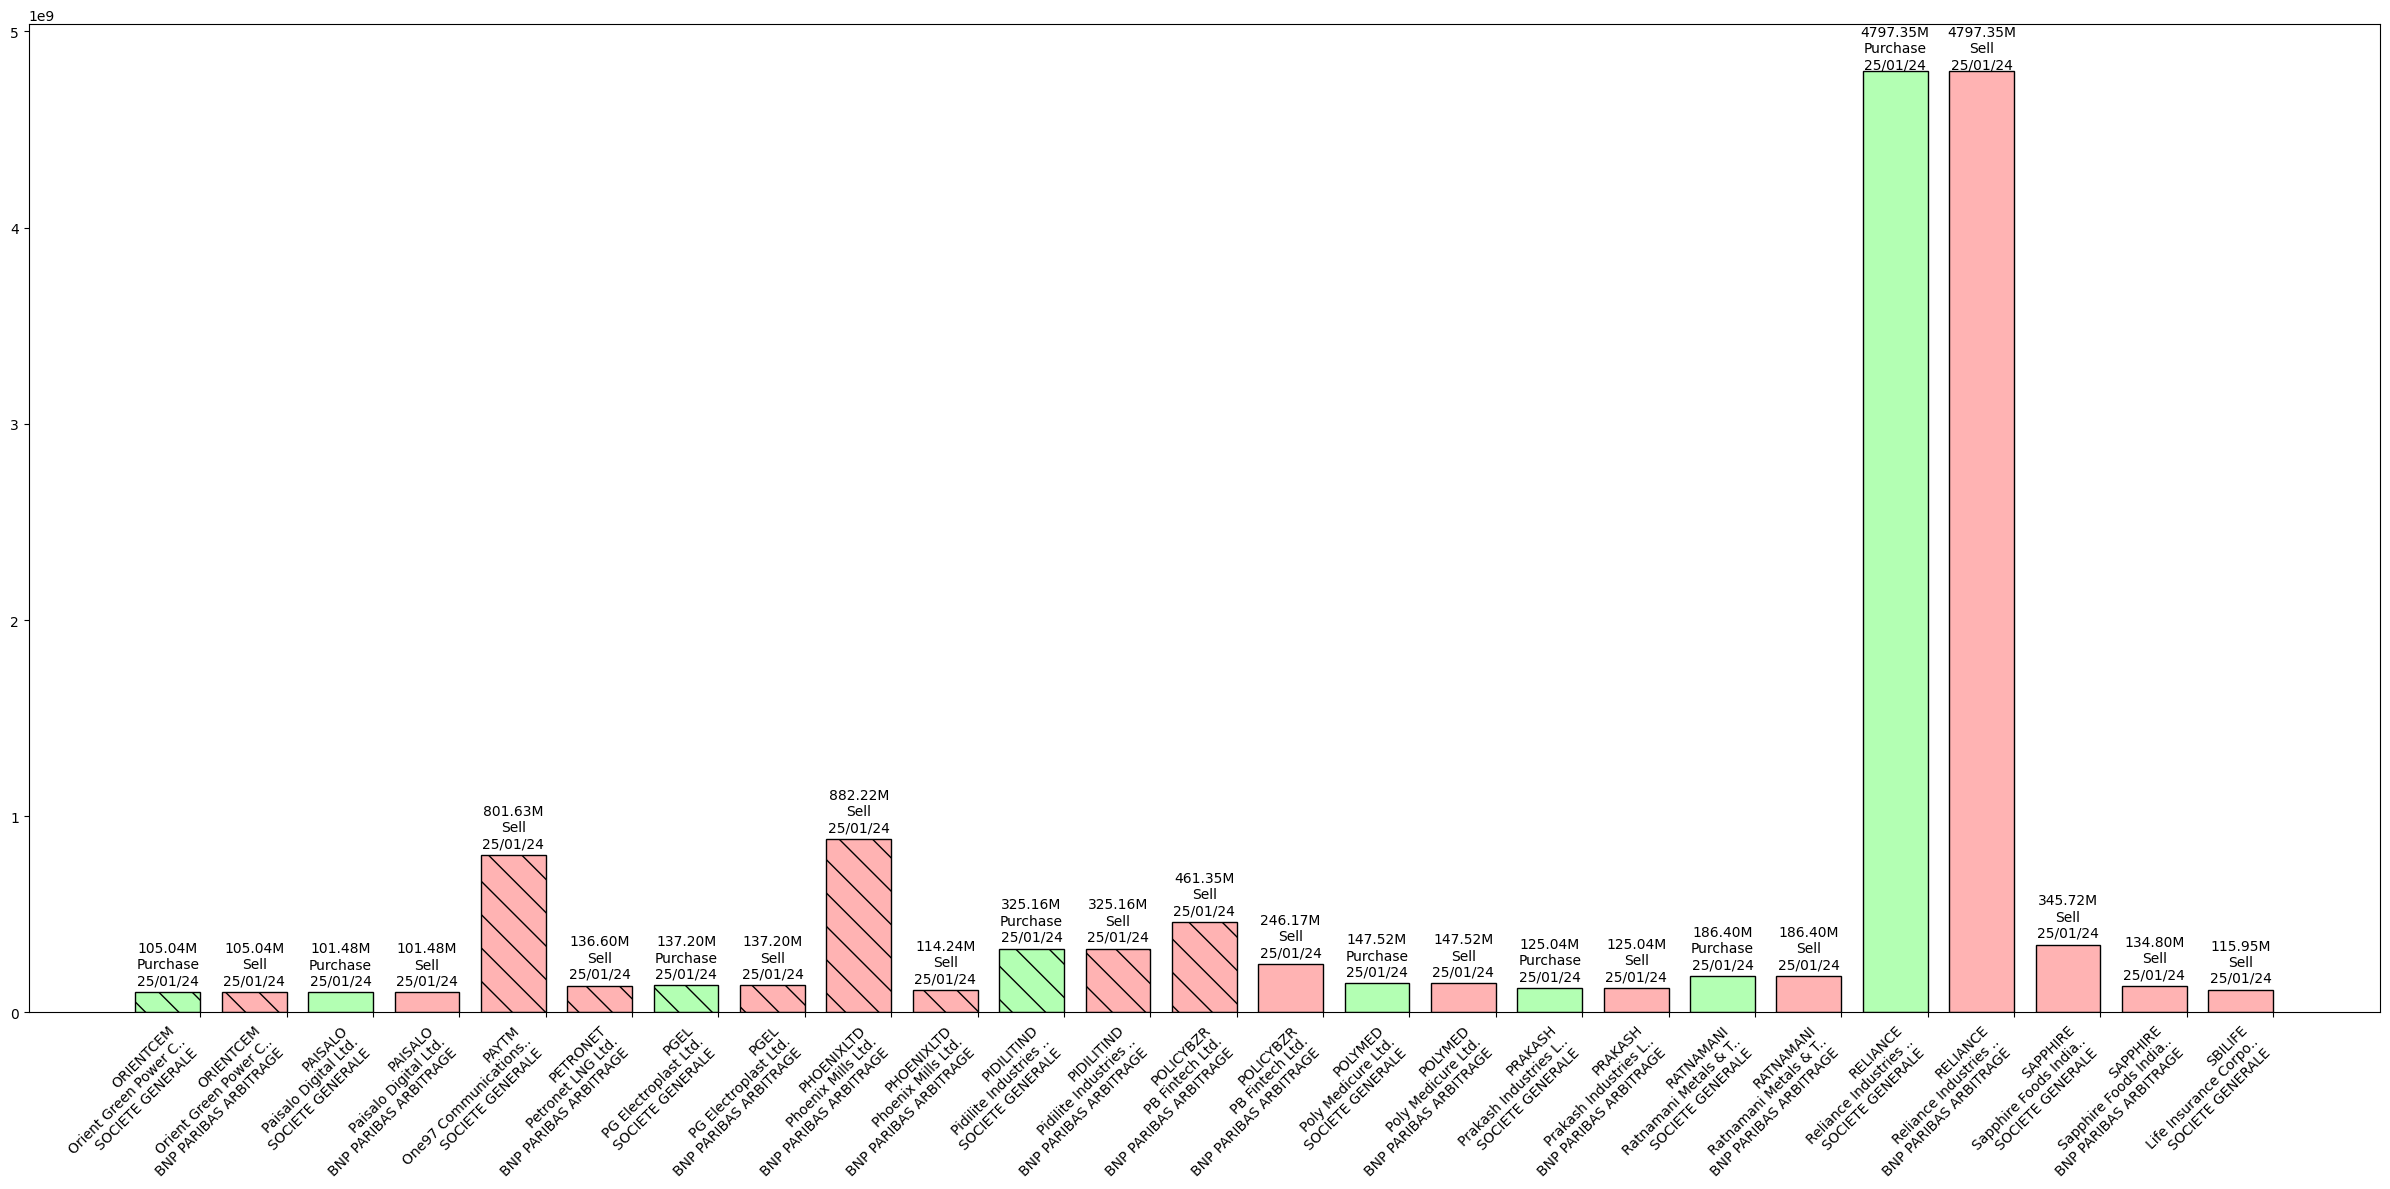

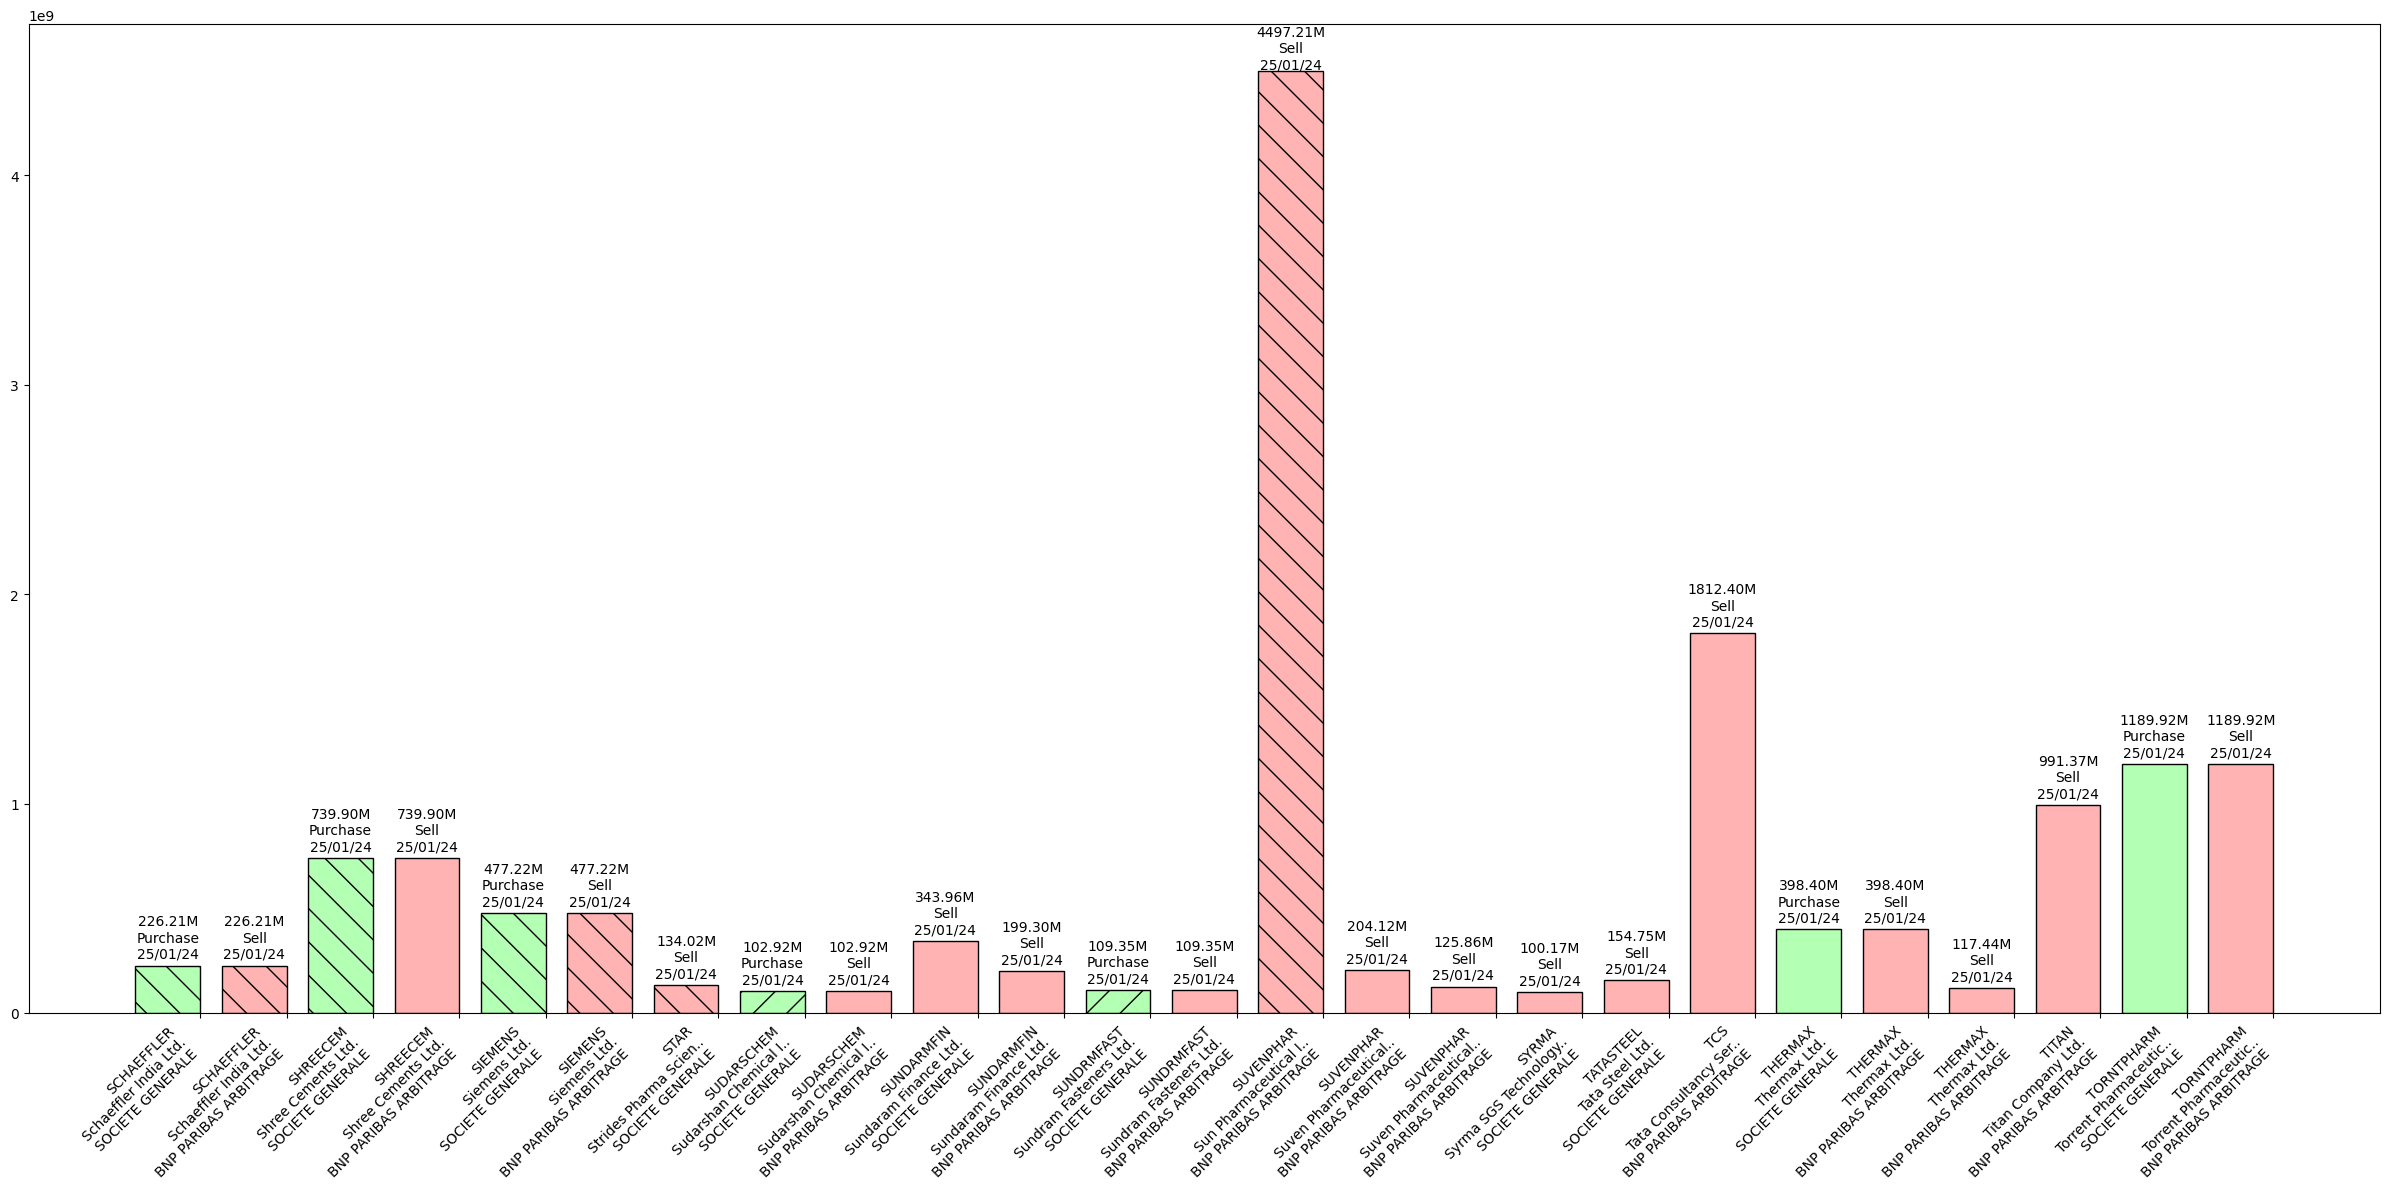

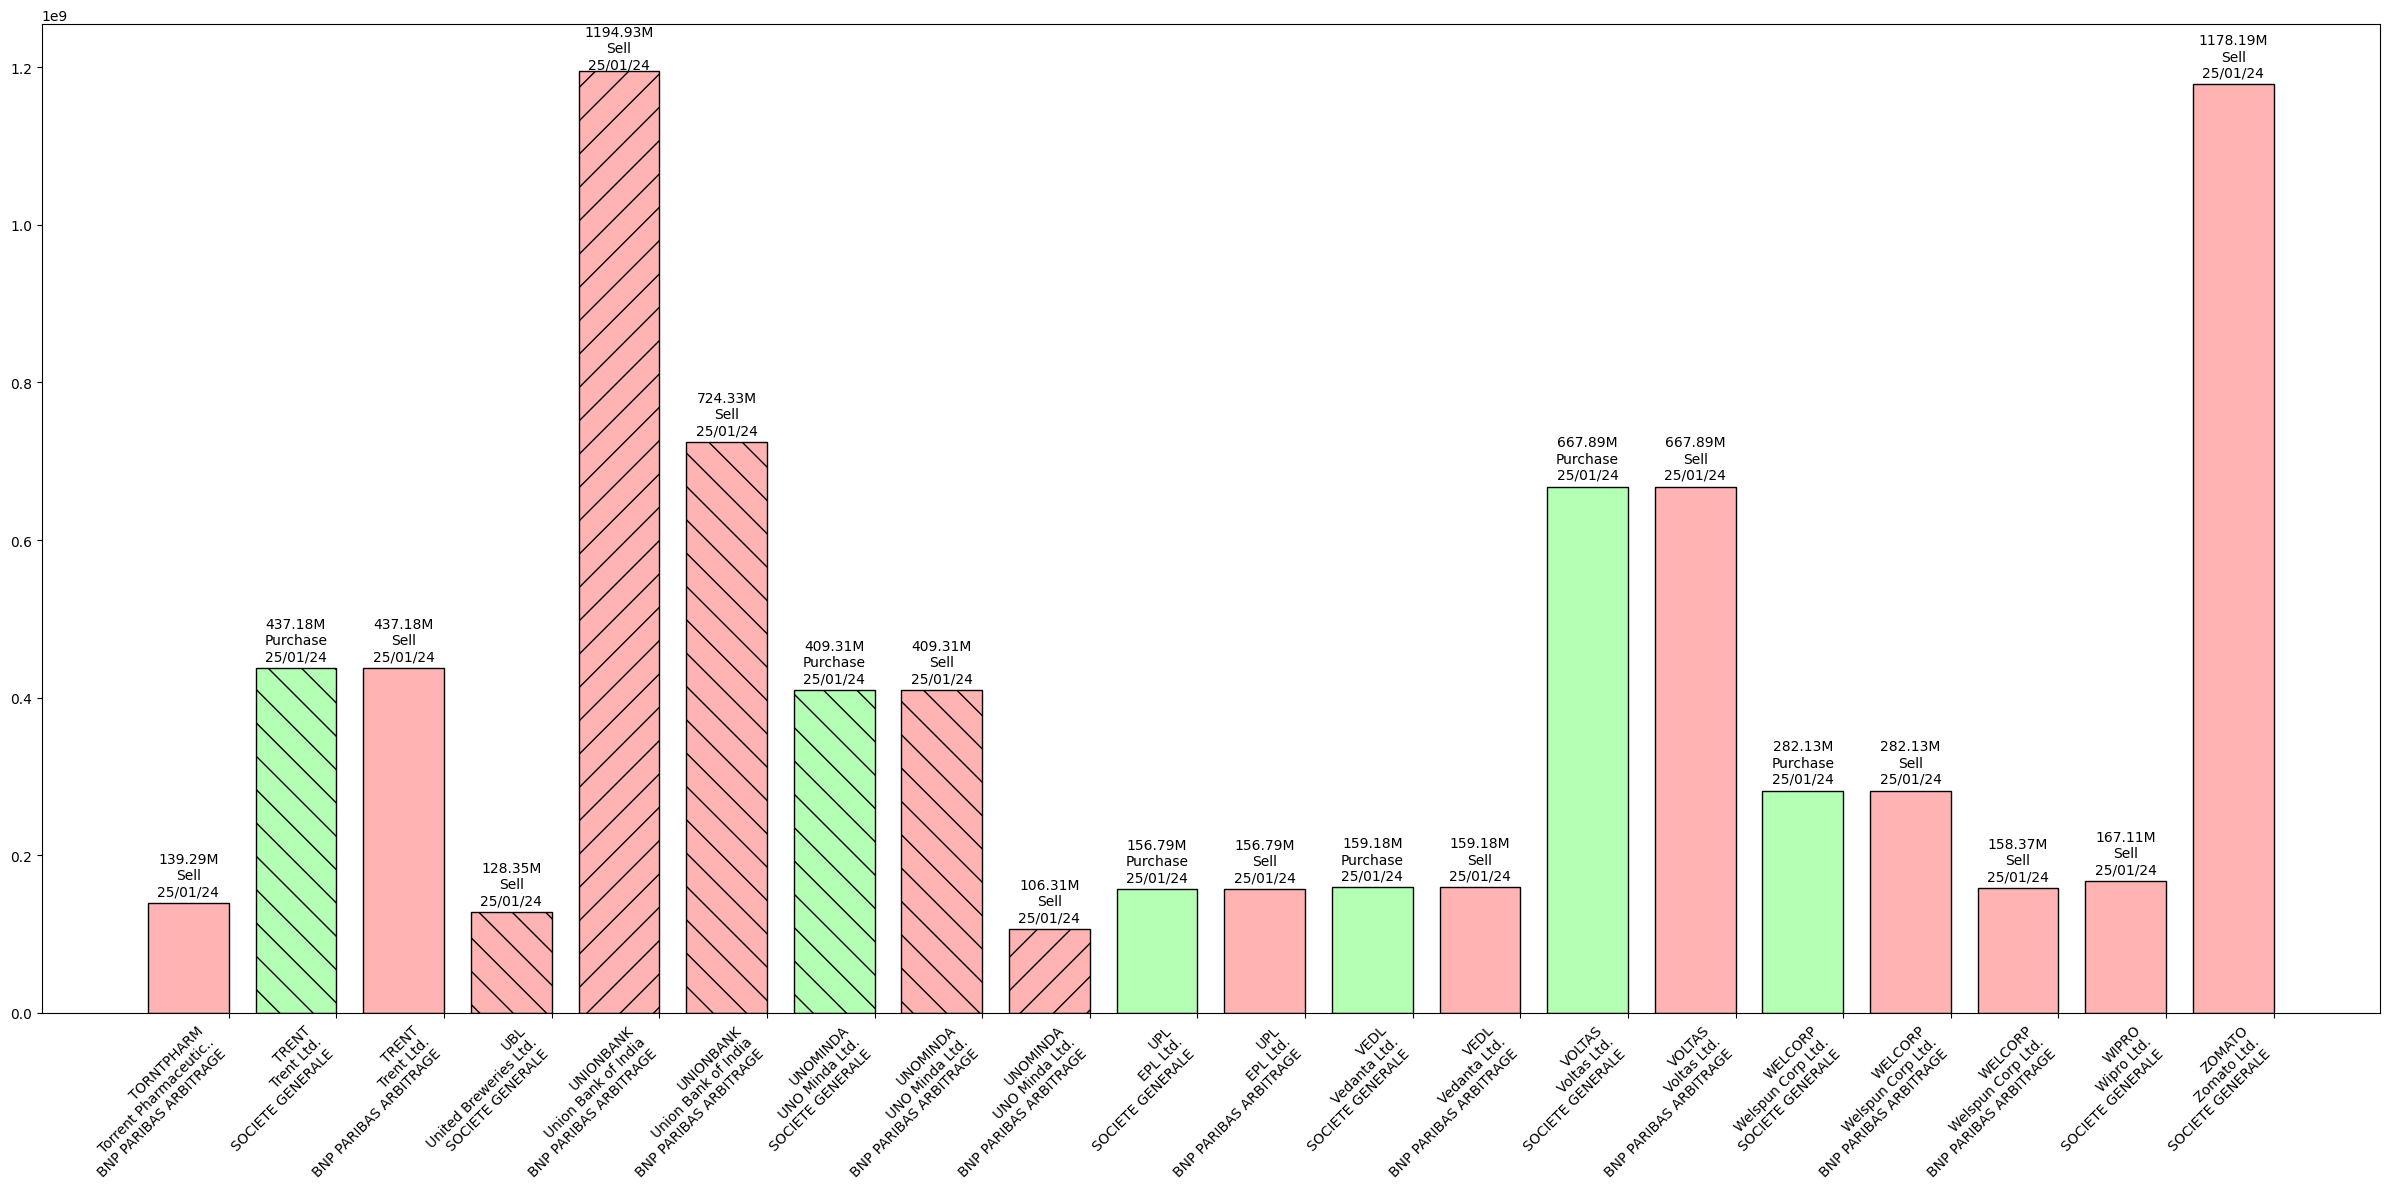

In [13]:
import os
import pandas as pd
from tabulate import tabulate
import smtplib
from email.mime.text import MIMEText
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re

pd.set_option('mode.chained_assignment', None)


# Path to the Excel file with values to match
values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip23012024.xlsx'

# Path to the folder with multiple Excel files
inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# Read values to match from the Excel file
values_df = pd.read_excel(values_excel_path)

# Extract the values from the relevant column (e.g., 'Scrip Code')
# values_to_match = values_df['Next 1000'].astype(str).str.lower().tolist()
values_to_match = values_df['Scrip Code'].astype(str).str.lower().tolist()

# Get a list of Excel files in the inbound folder
inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]

# Your send_email function
def send_email(subject, body):
    # Configure email settings
    sender_email = "healthyplusrich@gmail.com"
    receiver_email = "akirabots@gmail.com"
    password = "password"

    # Create email message
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email

    # Send email
    try:
        # Send email
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
            print("Email sent successfully")
    except Exception as e:
        print(f"Error sending email: {e}")

def display_top_transactions_charts(unique_action_row, max_charts=10):
    # Calculate the total number of charts
    rows_per_chart = 25  # You can adjust the value based on your requirements

    total_charts = int(np.ceil(len(unique_action_row) / rows_per_chart))

    # Iterate through the data and display a maximum of three charts for each set of 25 rows
    for chart_num in range(min(total_charts, max_charts)):
        start_index = chart_num * rows_per_chart
        end_index = (chart_num + 1) * rows_per_chart
        subset_data = unique_action_row.iloc[start_index:end_index]

        # Create a bar chart with unique patterns for bars with the same code
        plt.figure(figsize=(24, 12))
        
        # Adjust the width and spacing between bars
        width = 0.6
        spacing = 0.2

        # Define colors based on action
        mild_green = '#b3ffb3'  # Mild green color
        mild_red = '#ffb3b3'    # Mild red color
        mild_orange = '#ffcc99'  # Mild orange color
        mild_yellow = '#ffffb3'  # Mild yellow color

        colors = [
            mild_green if (isinstance(action, str) and action.lower() in ['acquisition', 'purchase']) else
            mild_red if (isinstance(action, str) and action.lower() in ['sell', 'disposal']) else
            mild_orange if (isinstance(action, str) and action.lower() == 'revoke') else
            mild_yellow for action in subset_data['Action']
        ]

        bars = plt.bar(np.arange(len(subset_data)) * (width + spacing), subset_data['Amount'], width=width, color=colors, edgecolor='black')

        # Display the 'Code' and 'Client Name' on the x-axis
        x_labels = [
            f"{code}\n{stock}\n{name}" 
            for code, stock, name,  in zip(subset_data['Code'],subset_data['Stock'], subset_data['Client Name'])
        ]
        
        # Center the labels between bars
        plt.xticks(np.arange(len(subset_data)) * (width + spacing) + width / 2, x_labels, rotation=45, ha='right')

        # Display the formatted amount, action, and file date on top of each bar
        for bar, amount, action, file_date in zip(bars, subset_data['Amount'], subset_data['Action'], subset_data['File Date']):
            formatted_amount = f'{amount / 1_000:.2f}K' if amount < 1_000_000 else f'{amount / 1_000_000:.2f}M'
            formatted_file_date = datetime.strptime(file_date, '%Y%m%d').strftime('%d/%m/%y')
            # Adjust the position calculation to ensure finite values
            position = min(bar.get_height() + 0.005 * max(subset_data['Amount']), max(subset_data['Amount']))

            plt.text(bar.get_x() + bar.get_width() / 2, position,
                     f'{formatted_amount}\n{action}\n{formatted_file_date}', ha='center', va='bottom')

        # Add unique patterns for bars with the same code
        unique_codes = subset_data['Code'].unique()
        for code, bar in zip(unique_codes, bars):
            indices = np.where(subset_data['Code'] == code)[0]
            if len(indices) > 1:
                for i, index in enumerate(indices):
                    bar.set_hatch('/')
                    if i % 2 == 1:
                        bar.set_hatch('\\')

        # Show the chart
        plt.tight_layout()
        plt.show()

def process_data(process_df, price_col='Average Price', quantity_col='Quantity'):
    # Calculate 'Amount' column

    process_df = process_df.copy()
    process_df['Amount'] = process_df[price_col] * process_df[quantity_col]

    # Get unique action rows
    unique_action_rows = process_df.groupby(['File Date', 'Code', 'Client Name']).filter(lambda x: x['Action'].nunique() == 1)
    print("Only Buy or Sell:")
    # print(tabulate(unique_action_rows, headers='keys', tablefmt='pretty', showindex=False))
    #Display Chart
    display_top_transactions_charts(unique_action_rows)

# Check if there are no files in the inbound folder
if not inbound_files:
    print("No files present in the inbound folder.")
else:
    # Dictionary to store results for each sheet name
    merged_results = {}

    # Iterate through each file
    for file_path in inbound_files:
        # Extract file date from the filename
        file_date = os.path.basename(file_path)[:8]

        # Read all sheets from the Excel file into a dictionary of DataFrames
        dfs = pd.read_excel(file_path, sheet_name=None)
        # Iterate through each sheet
        # print("values_to_match")
        # print(values_to_match)
        for sheet_name, df in dfs.items():
            # Convert the fourth column to lowercase and filter rows
            # filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().isin(map(str.lower, values_to_match))]
            filtered_rows = df[df['Code'].astype(str).str.lower().isin(map(str.lower, values_to_match))]

            #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains('|'.join(map(str.lower, values_to_match)))]
            #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains(r'\b(?:' + '|'.join(map(re.escape, map(str.lower, values_to_match))) + r')\b')]
            # print(df.iloc[:, 3].astype(str).str.lower())
            # Drop the specified columns
            # filtered_rows = filtered_rows.drop(columns=['Stock URL', 'ISIN', 'Stock Deals Page'])

            # Add a new column for file date | Modified for this error
            # filtered_rows['File Date'] = file_date Try using .loc[row_indexer,col_indexer] = value instead

            filtered_rows.loc[:, 'File Date'] = file_date


            # Check if the sheet name exists in the merged results dictionary
            if sheet_name not in merged_results:
                merged_results[sheet_name] = filtered_rows
            else:
                # Append the filtered rows to the existing sheet name
                merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])
            


    # Display merged results
    for sheet_name, merged_df in merged_results.items():
        # Display the sheet name
        print(f"\nSheet Name: {sheet_name}")
    
        # Check if there are any rows in the merged result
        if not merged_df.empty:
            # Sort the result based on 'Code' and 'File Date'
            #sorted_rows = merged_df.sort_values(by=['Code', 'File Date'])
            sorted_rows = merged_df.sort_values(by=['File Date', 'Code'], ascending=[False, True])

            # Drop rows with NaN values in the 'code' column
            sorted_rows = sorted_rows.dropna(subset=['Code'])
            
            # Check if there are any rows left after dropping NaN values
            # if not sorted_rows.empty:
            #     # Print the table if there are rows left
            #     print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))
            # else:
            #     print("All rows have been dropped due to NaN values in 'code' column.")
            
            # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
            if sheet_name == 'Bulk Block Deals':
                   process_data(sorted_rows, price_col='Average Price', quantity_col='Quantity')
            if sheet_name == 'Insider Disclosures':
                   process_data(sorted_rows, price_col='Avg. Price', quantity_col='Quantity')
            if sheet_name == 'SAST-Significant Acquisitions':
                   process_data(sorted_rows, price_col='Last Traded Price', quantity_col='Quantity')



            # Read the second sheet named 'Client' from Scrip.xlsx
            client_sheet_df = pd.read_excel(values_excel_path, sheet_name='Client', header=None, skiprows=1)
            clients_info = client_sheet_df.iloc[:, :2].rename(columns={0: 'Client Code', 1: 'Client Name'})
            clients_info['Client Code'] = clients_info['Client Code'].astype(str).str.lower()
    
            # Filter rows in sorted_rows where 'Client Name' partially matches 'Client Code' list
            special_clients = sorted_rows[sorted_rows['Client Name'].astype(str).str.lower().str.contains('|'.join(clients_info['Client Code'].tolist()), na=False)]
    
            # Send email with the result
            email_subject = f"Results for {sheet_name}"
            email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
            #send_email(email_subject, email_body)
    
            # # Move the file to the outbound folder after processing all sheets
            # outbound_file_path = os.path.join(outbound_folder_path, os.path.basename(file_path))
            # os.rename(file_path, outbound_file_path)
            # print(f"File moved to: {outbound_file_path}")
            
            # Display special clients in a separate tabular format
            if not special_clients.empty:
                print("\nSpecial Clients:")
                # print(tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False))

                # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
                if sheet_name == 'Bulk Block Deals':
                       process_data(special_clients, price_col='Average Price', quantity_col='Quantity')
                if sheet_name == 'Insider Disclosures':
                       process_data(special_clients, price_col='Avg. Price', quantity_col='Quantity')
                if sheet_name == 'SAST-Significant Acquisitions':
                       process_data(special_clients, price_col='Last Traded Price', quantity_col='Quantity')

                
                email_subject = f"Results for Special Client {sheet_name}"
                email_body = tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False)
                #send_email(email_subject, email_body)
                
            else:
                print("No special clients present.")
        else:
            print("No data present.")
pd.set_option('mode.chained_assignment', 'warn')


In [ ]:
Automated Daily Deal with Special Client and Fundamentals

In [ ]:
import os
import pandas as pd
from tabulate import tabulate
import smtplib
from email.mime.text import MIMEText
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re


# Path to the Excel file with values to match
values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip120120241753.xlsx'

# Path to the folder with multiple Excel files
inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# Read values to match from the Excel file
values_df = pd.read_excel(values_excel_path)

# Extract the values from the relevant column (e.g., 'Scrip Code')
# values_to_match = values_df['Next 1000'].astype(str).str.lower().tolist()
values_to_match = values_df['Scrip Code'].astype(str).str.lower().tolist()

# Get a list of Excel files in the inbound folder
inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]

def get_stock_info(nse_code):
    file_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Fundamental\NSE_Fundamental.xlsx'

    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_path)
    # Filter the DataFrame based on the NSE code
    filtered_df = df[df['NSE code'] == nse_code]

    if filtered_df.empty:
        return pd.DataFrame()

    # Select only the required columns
    result_df = filtered_df[['Stock Name','Industry Name', 'Current Price Rs', 'Price to Book Value', 'Industry Price to Book TTM','PE TTM Price to Earnings','RSI','Long Term Debt To Equity Annual','ROE Annual %','% Distance from 52week high','EPS Annual Rs','FII holding current Qtr %']]
    
    return result_df
    
def display_top_transactions_charts(unique_action_row, max_charts=10):
    # Calculate the total number of charts
    rows_per_chart = 25  # You can adjust the value based on your requirements

    total_charts = int(np.ceil(len(unique_action_row) / rows_per_chart))

    # Iterate through the data and display a maximum of three charts for each set of 25 rows
    for chart_num in range(min(total_charts, max_charts)):
        start_index = chart_num * rows_per_chart
        end_index = (chart_num + 1) * rows_per_chart
        subset_data = unique_action_row.iloc[start_index:end_index]

        # Create a bar chart with unique patterns for bars with the same code
        plt.figure(figsize=(24, 12))
        
        # Adjust the width and spacing between bars
        width = 0.6
        spacing = 0.2

        # Define colors based on action
        mild_green = '#b3ffb3'  # Mild green color
        mild_red = '#ffb3b3'    # Mild red color
        mild_orange = '#ffcc99'  # Mild orange color
        mild_yellow = '#ffffb3'  # Mild yellow color

        colors = [
            mild_green if (isinstance(action, str) and action.lower() in ['acquisition', 'purchase']) else
            mild_red if (isinstance(action, str) and action.lower() in ['sell', 'disposal']) else
            mild_orange if (isinstance(action, str) and action.lower() == 'revoke') else
            mild_yellow for action in subset_data['Action']
        ]

        bars = plt.bar(np.arange(len(subset_data)) * (width + spacing), subset_data['Amount'], width=width, color=colors, edgecolor='black')

        # Display the 'Code' and 'Client Name' on the x-axis
        x_labels = [
            f"{code}\n{stock}\n{name}" 
            for code, stock, name,  in zip(subset_data['Code'],subset_data['Stock'], subset_data['Client Name'])
        ]
        
        # Center the labels between bars
        plt.xticks(np.arange(len(subset_data)) * (width + spacing) + width / 2, x_labels, rotation=45, ha='right')

        # Display the formatted amount, action, and file date on top of each bar
        for bar, amount, action, file_date in zip(bars, subset_data['Amount'], subset_data['Action'], subset_data['File Date']):
            formatted_amount = f'{amount / 1_000:.2f}K' if amount < 1_000_000 else f'{amount / 1_000_000:.2f}M'
            formatted_file_date = datetime.strptime(file_date, '%Y%m%d').strftime('%d/%m/%y')
            # Adjust the position calculation to ensure finite values
            position = min(bar.get_height() + 0.005 * max(subset_data['Amount']), max(subset_data['Amount']))

            plt.text(bar.get_x() + bar.get_width() / 2, position,
                     f'{formatted_amount}\n{action}\n{formatted_file_date}', ha='center', va='bottom')

        # Add unique patterns for bars with the same code
        unique_codes = subset_data['Code'].unique()
        for code, bar in zip(unique_codes, bars):
            indices = np.where(subset_data['Code'] == code)[0]
            if len(indices) > 1:
                for i, index in enumerate(indices):
                    bar.set_hatch('/')
                    if i % 2 == 1:
                        bar.set_hatch('\\')

        # Show the chart
        plt.tight_layout()
        plt.show()
        
def process_data(process_df, price_col='Average Price', quantity_col='Quantity'):
    # Calculate 'Amount' column
    process_df = process_df.copy()
    process_df['Amount'] = process_df[price_col] * process_df[quantity_col]

    # Get unique action rows
    unique_action_rows = process_df.groupby(['File Date', 'Code', 'Client Name']).filter(lambda x: x['Action'].nunique() == 1)
    print("Only Buy or Sell:")
    # print(tabulate(unique_action_rows, headers='keys', tablefmt='pretty', showindex=False))

    # # Collecting Fundamental data for unique buy or sell
    # collected_data = pd.DataFrame()

    # # Iterate through each unique code and append stock info to collected_data
    # for code in unique_action_rows['Code'].unique():
    #     stock_info = get_stock_info(code)
    #     collected_data = pd.concat([collected_data, stock_info], ignore_index=True)

    # # Display the collected DataFrame
 
    # print(tabulate(collected_data, headers='keys', tablefmt='pretty', showindex=False))

    # Display Chart
    display_top_transactions_charts(unique_action_rows)


# Check if there are no files in the inbound folder
if not inbound_files:
    print("No files present in the inbound folder.")
else:
    # Dictionary to store results for each sheet name
    merged_results = {}

    # Iterate through each file
    for file_path in inbound_files:
        # Extract file date from the filename
        file_date = os.path.basename(file_path)[:8]

        # Read all sheets from the Excel file into a dictionary of DataFrames
        dfs = pd.read_excel(file_path, sheet_name=None)
        # Iterate through each sheet
        # print("values_to_match")
        # print(values_to_match)
        for sheet_name, df in dfs.items():
            # Convert the fourth column to lowercase and filter rows
            # filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().isin(map(str.lower, values_to_match))]

            filtered_rows = df[df['Code'].astype(str).str.lower().isin(map(str.lower, values_to_match))]


            
            #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains('|'.join(map(str.lower, values_to_match)))]
            #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains(r'\b(?:' + '|'.join(map(re.escape, map(str.lower, values_to_match))) + r')\b')]
            # print(df.iloc[:, 3].astype(str).str.lower())
            # Drop the specified columns
            filtered_rows = filtered_rows.drop(columns=['Stock URL', 'ISIN', 'Stock Deals Page'])

            # Add a new column for file date
            filtered_rows['File Date'] = file_date

            # Check if the sheet name exists in the merged results dictionary
            if sheet_name not in merged_results:
                merged_results[sheet_name] = filtered_rows
            else:
                # Append the filtered rows to the existing sheet name
                merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])
            


    # Display merged results
    for sheet_name, merged_df in merged_results.items():
        # Display the sheet name
        print(f"\nSheet Name: {sheet_name}")
    
        # Check if there are any rows in the merged result
        if not merged_df.empty:
            # Sort the result based on 'Code' and 'File Date'
            #sorted_rows = merged_df.sort_values(by=['Code', 'File Date'])
            sorted_rows = merged_df.sort_values(by=['File Date', 'Code'], ascending=[False, True])

            # Display the sorted rows in a tabular format
            # print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))
            
            # get_stock_info(nse_code)
            
            # # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
            # if sheet_name == 'Bulk Block Deals':
            #        process_data(sorted_rows, price_col='Average Price', quantity_col='Quantity')
            # if sheet_name == 'Insider Disclosures':
            #        process_data(sorted_rows, price_col='Avg. Price', quantity_col='Quantity')
            # if sheet_name == 'SAST-Significant Acquisitions':
            #        process_data(sorted_rows, price_col='Last Traded Price', quantity_col='Quantity')



            # Read the second sheet named 'Client' from Scrip.xlsx
            client_sheet_df = pd.read_excel(values_excel_path, sheet_name='Client', header=None, skiprows=1)
            clients_info = client_sheet_df.iloc[:, :2].rename(columns={0: 'Client Code', 1: 'Client Name'})
            clients_info['Client Code'] = clients_info['Client Code'].astype(str).str.lower()
    
            # Filter rows in sorted_rows where 'Client Name' partially matches 'Client Code' list
            special_clients = sorted_rows[sorted_rows['Client Name'].astype(str).str.lower().str.contains('|'.join(clients_info['Client Code'].tolist()), na=False)]
    
            # Send email with the result
            email_subject = f"Results for {sheet_name}"
            email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
            #send_email(email_subject, email_body)
    
            # # Move the file to the outbound folder after processing all sheets
            # outbound_file_path = os.path.join(outbound_folder_path, os.path.basename(file_path))
            # os.rename(file_path, outbound_file_path)
            # print(f"File moved to: {outbound_file_path}")
            
            # Display special clients in a separate tabular format
            if not special_clients.empty:
                print("\nSpecial Clients:")
                # print(tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False))

                # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
                if sheet_name == 'Bulk Block Deals':
                       process_data(special_clients, price_col='Average Price', quantity_col='Quantity')
                if sheet_name == 'Insider Disclosures':
                       process_data(special_clients, price_col='Avg. Price', quantity_col='Quantity')
                if sheet_name == 'SAST-Significant Acquisitions':
                       process_data(special_clients, price_col='Last Traded Price', quantity_col='Quantity')

                
                email_subject = f"Results for Special Client {sheet_name}"
                email_body = tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False)
                #send_email(email_subject, email_body)
                
            else:
                print("No special clients present.")
        else:
            print("No data present.")

In [ ]:
# import os
# import pandas as pd
# from tabulate import tabulate
# import smtplib
# from email.mime.text import MIMEText
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import datetime
# import re


# # Path to the Excel file with values to match
# values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip23012024.xlsx'

# # Path to the folder with multiple Excel files
# inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
# outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# # Read values to match from the Excel file
# # values_df = pd.read_excel(values_excel_path)

# # Extract the values from the relevant column (e.g., 'Scrip Code')
# # Read the second sheet named 'Sentiment' from Scrip.xlsx
# sentiment_sheet_df = pd.read_excel(values_excel_path, sheet_name='Sentiment', header=None, skiprows=1)
# sentiment_keywords = sentiment_sheet_df.iloc[:, 0].astype(str).str.lower().tolist()
# # print(sentiment_keywords)
# values_to_match = sentiment_keywords

# # Get a list of Excel files in the inbound folder
# inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]


# def display_top_transactions_charts(unique_action_row, max_charts=10):
#     # Calculate the total number of charts
#     rows_per_chart = 25  # You can adjust the value based on your requirements

#     total_charts = int(np.ceil(len(unique_action_row) / rows_per_chart))

#     # Iterate through the data and display a maximum of three charts for each set of 25 rows
#     for chart_num in range(min(total_charts, max_charts)):
#         start_index = chart_num * rows_per_chart
#         end_index = (chart_num + 1) * rows_per_chart
#         subset_data = unique_action_row.iloc[start_index:end_index]

#         # Create a bar chart with unique patterns for bars with the same code
#         plt.figure(figsize=(24, 12))
        
#         # Adjust the width and spacing between bars
#         width = 0.6
#         spacing = 0.2

#         # Define colors based on action
#         mild_green = '#b3ffb3'  # Mild green color
#         mild_red = '#ffb3b3'    # Mild red color
#         mild_orange = '#ffcc99'  # Mild orange color
#         mild_yellow = '#ffffb3'  # Mild yellow color

#         colors = [
#             mild_green if (isinstance(action, str) and action.lower() in ['acquisition', 'purchase']) else
#             mild_red if (isinstance(action, str) and action.lower() in ['sell', 'disposal']) else
#             mild_orange if (isinstance(action, str) and action.lower() == 'revoke') else
#             mild_yellow for action in subset_data['Action']
#         ]

#         bars = plt.bar(np.arange(len(subset_data)) * (width + spacing), subset_data['Amount'], width=width, color=colors, edgecolor='black')

#         # Display the 'Code' and 'Client Name' on the x-axis
#         x_labels = [
#             f"{code}\n{stock}\n{name}" 
#             for code, stock, name,  in zip(subset_data['Code'],subset_data['Stock'], subset_data['Client Name'])
#         ]
        
#         # Center the labels between bars
#         plt.xticks(np.arange(len(subset_data)) * (width + spacing) + width / 2, x_labels, rotation=45, ha='right')

#         # Display the formatted amount, action, and file date on top of each bar
#         for bar, amount, action, file_date in zip(bars, subset_data['Amount'], subset_data['Action'], subset_data['Date']):
#             formatted_amount = f'{amount / 1_000:.2f}K' if amount < 1_000_000 else f'{amount / 1_000_000:.2f}M'
#             formatted_file_date = datetime.strptime(file_date, '%d-%m-%Y').strftime('%d/%m/%y')
#             # Adjust the position calculation to ensure finite values
#             position = min(bar.get_height() + 0.005 * max(subset_data['Amount']), max(subset_data['Amount']))

#             plt.text(bar.get_x() + bar.get_width() / 2, position,
#                      f'{formatted_amount}\n{action}\n{formatted_file_date}', ha='center', va='bottom')

#         # Add unique patterns for bars with the same code
#         unique_codes = subset_data['Code'].unique()
#         for code, bar in zip(unique_codes, bars):
#             indices = np.where(subset_data['Code'] == code)[0]
#             if len(indices) > 1:
#                 for i, index in enumerate(indices):
#                     bar.set_hatch('/')
#                     if i % 2 == 1:
#                         bar.set_hatch('\\')

#         # Show the chart
#         plt.tight_layout()
#         plt.show()

# def process_data(process_df, price_col='Avg. Price', quantity_col='Quantity'):
#     # Calculate 'Amount' column

#     process_df = process_df.copy()
#     process_df['Amount'] = process_df[price_col].str.replace(',', '').astype(float) * process_df[quantity_col].str.replace(',', '').astype(float)

#     # Get unique action rows
#     unique_action_rows = process_df.groupby(['Date', 'Code', 'Client Name']).filter(lambda x: x['Action'].nunique() == 1)
#     print("Only Buy or Sell:")
#     print(tabulate(unique_action_rows, headers='keys', tablefmt='pretty', showindex=False))
#     # Display Chart
#     display_top_transactions_charts(unique_action_rows)

# # Check if there are no files in the inbound folder
# if not inbound_files:
#     print("No files present in the inbound folder.")
# else:
#     # Dictionary to store results for each sheet name
#     merged_results = {}

#     # Iterate through each file
#     for file_path in inbound_files:
#         # Extract file date from the filename
#         file_date = os.path.basename(file_path)[:8]

#         # Read all sheets from the Excel file into a dictionary of DataFrames
#         dfs = pd.read_excel(file_path, sheet_name=None,skiprows=1)


#         # print(dfs)


#         # Iterate through each sheet
#         for sheet_name, df in dfs.items():
#             # Convert the fourth column to lowercase and filter rows
#             filtered_rows = df[df.iloc[:, 0].str.lower().isin(map(str.lower, values_to_match))]
#             print(filtered_rows)
#             # Add a new column for file date
#             filtered_rows['File Date'] = file_date

#             # Check if the sheet name exists in the merged results dictionary
#             if sheet_name not in merged_results:
#                 merged_results[sheet_name] = filtered_rows
#             else:
#                 # Append the filtered rows to the existing sheet name
#                 merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])

#     # Display merged results
#     for sheet_name, merged_df in merged_results.items():
#         # Display the sheet name
#         print(f"\nSheet Name: {sheet_name}")

#         # Check if there are any rows in the merged result
#         if not merged_df.empty:
#             # Sort the result based on 'Code' and 'File Date'
#             sorted_rows = merged_df.sort_values(by=['File Date', 'Code'], ascending=[False, True])

#             # Drop rows with NaN values in the 'code' column
#             sorted_rows = sorted_rows.dropna(subset=['Code'])

#             # Check if there are any rows left after dropping NaN values
#             if not sorted_rows.empty:
#                 # Print the table if there are rows left
#                 print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))
#             else:
#                 print("All rows have been dropped due to NaN values in 'code' column.")

#             # Calculate the new column by multiplying "Avg. Price" and "Quantity" for 'Bulk Block Deals'
#             if sheet_name == 'Latest Bulk and Block Deals':
#                    process_data(sorted_rows, price_col='Avg. Price', quantity_col='Quantity')

#             # Read the second sheet named 'Client' from Scrip.xlsx
#             client_sheet_df = pd.read_excel(values_excel_path, sheet_name='Client', header=None, skiprows=1)
#             clients_info = client_sheet_df.iloc[:, :2].rename(columns={0: 'Client Code', 1: 'Client Name'})
#             clients_info['Client Code'] = clients_info['Client Code'].astype(str).str.lower()

#             # Filter rows in sorted_rows where 'Client Name' partially matches 'Client Code' list
#             special_clients = sorted_rows[sorted_rows['Client Name'].astype(str).str.lower().str.contains('|'.join(clients_info['Client Code'].tolist()), na=False)]

#             # Send email with the result
#             email_subject = f"Results for {sheet_name}"
#             email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
#             # send_email(email_subject, email_body)

#             # Display special clients in a separate tabular format
#             if not special_clients.empty:
#                 print("\nSpecial Clients:")
#                 print(tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False))

#                 # Calculate the new column by multiplying "Avg. Price" and "Quantity" for 'Bulk Block Deals'
#                 if sheet_name == 'Latest Bulk and Block Deals':
#                     process_data(special_clients, price_col='Avg. Price', quantity_col='Quantity')

#                 email_subject = f"Results for Special Client {sheet_name}"
#                 email_body = tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False)
#                 # send_email(email_subject, email_body)

#             else:
#                 print("No special clients present.")
#         else:
#             print("No data present.")


In [ ]:
# import os
# import pandas as pd
# from tabulate import tabulate
# import smtplib
# from email.mime.text import MIMEText
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import datetime
# import re


# # Path to the Excel file with values to match
# values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip23012024.xlsx'

# # Path to the folder with multiple Excel files
# inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
# outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# # Read values to match from the Excel file
# # values_df = pd.read_excel(values_excel_path)
# values_df = pd.read_excel(values_excel_path, sheet_name='Sentiment')
# # print(values_df)

# # Extract the values from the relevant column (e.g., 'Scrip Code')
# # values_to_match = values_df['Next 1000'].astype(str).str.lower().tolist()
# values_to_match = values_df['Keyword'].astype(str).str.lower().tolist()
# # print(values_to_match)
# # Get a list of Excel files in the inbound folder
# inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]



# def display_top_transactions_charts(unique_action_row, max_charts=10):
#     # Calculate the total number of charts
#     rows_per_chart = 25  # You can adjust the value based on your requirements

#     total_charts = int(np.ceil(len(unique_action_row) / rows_per_chart))

#     # Iterate through the data and display a maximum of three charts for each set of 25 rows
#     for chart_num in range(min(total_charts, max_charts)):
#         start_index = chart_num * rows_per_chart
#         end_index = (chart_num + 1) * rows_per_chart
#         subset_data = unique_action_row.iloc[start_index:end_index]

#         # Create a bar chart with unique patterns for bars with the same code
#         plt.figure(figsize=(24, 12))
        
#         # Adjust the width and spacing between bars
#         width = 0.6
#         spacing = 0.2

#         # Define colors based on action
#         mild_green = '#b3ffb3'  # Mild green color
#         mild_red = '#ffb3b3'    # Mild red color
#         mild_orange = '#ffcc99'  # Mild orange color
#         mild_yellow = '#ffffb3'  # Mild yellow color

#         colors = [
#             mild_green if (isinstance(action, str) and action.lower() in ['acquisition', 'purchase']) else
#             mild_red if (isinstance(action, str) and action.lower() in ['sell', 'disposal']) else
#             mild_orange if (isinstance(action, str) and action.lower() == 'revoke') else
#             mild_yellow for action in subset_data['Action']
#         ]

#         bars = plt.bar(np.arange(len(subset_data)) * (width + spacing), subset_data['Amount'], width=width, color=colors, edgecolor='black')

#         # Display the 'Code' and 'Client Name' on the x-axis
#         x_labels = [
#             f"{code}\n{stock}\n{name}" 
#             for code, stock, name,  in zip(subset_data['Code'],subset_data['Stock'], subset_data['Client Name'])
#         ]
        
#         # Center the labels between bars
#         plt.xticks(np.arange(len(subset_data)) * (width + spacing) + width / 2, x_labels, rotation=45, ha='right')

#         # Display the formatted amount, action, and file date on top of each bar
#         for bar, amount, action, file_date in zip(bars, subset_data['Amount'], subset_data['Action'], subset_data['File Date']):
#             formatted_amount = f'{amount / 1_000:.2f}K' if amount < 1_000_000 else f'{amount / 1_000_000:.2f}M'
#             formatted_file_date = datetime.strptime(file_date, '%Y%m%d').strftime('%d/%m/%y')
#             # Adjust the position calculation to ensure finite values
#             position = min(bar.get_height() + 0.005 * max(subset_data['Amount']), max(subset_data['Amount']))

#             plt.text(bar.get_x() + bar.get_width() / 2, position,
#                      f'{formatted_amount}\n{action}\n{formatted_file_date}', ha='center', va='bottom')

#         # Add unique patterns for bars with the same code
#         unique_codes = subset_data['Code'].unique()
#         for code, bar in zip(unique_codes, bars):
#             indices = np.where(subset_data['Code'] == code)[0]
#             if len(indices) > 1:
#                 for i, index in enumerate(indices):
#                     bar.set_hatch('/')
#                     if i % 2 == 1:
#                         bar.set_hatch('\\')

#         # Show the chart
#         plt.tight_layout()
#         plt.show()

# def process_data(process_df, price_col='Average Price', quantity_col='Quantity'):
#     # Calculate 'Amount' column

#     process_df = process_df.copy()
#     process_df['Amount'] = process_df[price_col] * process_df[quantity_col]

#     # Get unique action rows
#     unique_action_rows = process_df.groupby(['File Date', 'Code', 'Client Name']).filter(lambda x: x['Action'].nunique() == 1)
#     print("Only Buy or Sell:")
#     print(tabulate(unique_action_rows, headers='keys', tablefmt='pretty', showindex=False))
#     #Display Chart
#     display_top_transactions_charts(unique_action_rows)

# # Check if there are no files in the inbound folder
# if not inbound_files:
#     print("No files present in the inbound folder.")
# else:
#     # Dictionary to store results for each sheet name
#     merged_results = {}

#     # Iterate through each file
#     for file_path in inbound_files:
#         # Extract file date from the filename
#         file_date = os.path.basename(file_path)[:8]

#         # Read all sheets from the Excel file into a dictionary of DataFrames
#         dfs = pd.read_excel(file_path,skiprows=1)
#         # dfs = pd.read_excel(file_path, sheet_name='Sheet1', header=1)  # Headers start from the seventh row

#         # Iterate through each sheet
#         print("values_to_match")
#         # print(dfs)
#         for sheet_name, df in dfs.items():
#             # Convert the fourth column to lowercase and filter rows
#             # filtered_rows = df[df.iloc[:, 0].astype(str).str.lower().isin(map(str.lower, values_to_match))]
#             # print(df)
#             filtered_rows = df[df.astype(str).str.lower().isin(values_to_match)]

#             print(filtered_rows)
#             #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains('|'.join(map(str.lower, values_to_match)))]
#             #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains(r'\b(?:' + '|'.join(map(re.escape, map(str.lower, values_to_match))) + r')\b')]
#             # print(df.iloc[:, 3].astype(str).str.lower())
#             # Drop the specified columns
#             # filtered_rows = filtered_rows.drop(columns=['Stock URL', 'ISIN', 'Stock Deals Page'])

#             # Add a new column for file date
#             filtered_rows['File Date'] = file_date
#             # print(filtered_rows)
#             # Check if the sheet name exists in the merged results dictionary
#             if sheet_name not in merged_results:
#                 merged_results[sheet_name] = filtered_rows
#             else:
#                 # Append the filtered rows to the existing sheet name
#                 merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])
            


#     # Display merged results
#     for sheet_name, merged_df in merged_results.items():
#         # Display the sheet name
#         print(f"\nSheet Name: {sheet_name}")
    
#         # Check if there are any rows in the merged result
#         if not merged_df.empty:
#             # Sort the result based on 'Code' and 'File Date'
#             #sorted_rows = merged_df.sort_values(by=['Code', 'File Date'])
#             print(merged_df)
#             sorted_rows = merged_df.sort_values(by=['File Date', 'Stock'], ascending=[False, True])
#             print(sorted_rows)
#             # Drop rows with NaN values in the 'code' column
#             sorted_rows = sorted_rows.dropna(subset=['Stock'])
            
#             # Check if there are any rows left after dropping NaN values
#             if not sorted_rows.empty:
#                 # Print the table if there are rows left
#                 print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))
#             else:
#                 print("All rows have been dropped due to NaN values in 'code' column.")
            
#             # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
#             if sheet_name == 'Bulk Block Deals':
#                    process_data(sorted_rows, price_col='Average Price', quantity_col='Quantity')
#             if sheet_name == 'Insider Disclosures':
#                    process_data(sorted_rows, price_col='Avg. Price', quantity_col='Quantity')
#             if sheet_name == 'SAST-Significant Acquisitions':
#                    process_data(sorted_rows, price_col='Last Traded Price', quantity_col='Quantity')



#             # Read the second sheet named 'Client' from Scrip.xlsx
#             client_sheet_df = pd.read_excel(values_excel_path, sheet_name='Client', header=None, skiprows=1)
#             clients_info = client_sheet_df.iloc[:, :2].rename(columns={0: 'Client Code', 1: 'Client Name'})
#             clients_info['Client Code'] = clients_info['Client Code'].astype(str).str.lower()
    
#             # Filter rows in sorted_rows where 'Client Name' partially matches 'Client Code' list
#             special_clients = sorted_rows[sorted_rows['Client Name'].astype(str).str.lower().str.contains('|'.join(clients_info['Client Code'].tolist()), na=False)]
    
#             # Send email with the result
#             email_subject = f"Results for {sheet_name}"
#             email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
#             #send_email(email_subject, email_body)
    
#             # # Move the file to the outbound folder after processing all sheets
#             # outbound_file_path = os.path.join(outbound_folder_path, os.path.basename(file_path))
#             # os.rename(file_path, outbound_file_path)
#             # print(f"File moved to: {outbound_file_path}")
            
#             # Display special clients in a separate tabular format
#             if not special_clients.empty:
#                 print("\nSpecial Clients:")
#                 # print(tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False))

#                 # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
#                 if sheet_name == 'Bulk Block Deals':
#                        process_data(special_clients, price_col='Average Price', quantity_col='Quantity')
#                 if sheet_name == 'Insider Disclosures':
#                        process_data(special_clients, price_col='Avg. Price', quantity_col='Quantity')
#                 if sheet_name == 'SAST-Significant Acquisitions':
#                        process_data(special_clients, price_col='Last Traded Price', quantity_col='Quantity')

                
#                 email_subject = f"Results for Special Client {sheet_name}"
#                 email_body = tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False)
#                 #send_email(email_subject, email_body)
                
#             else:
#                 print("No special clients present.")
#         else:
#             print("No data present.")